### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster



In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 50) 

## Load the data

In [4]:
comercios = pd.read_csv(r'C:\Users\ASUS\OneDrive - Escuela Superior Politécnica del Litoral\Proyectos Broadnet\ComerciosInfo.csv')
ventas = pd.read_csv(r'C:\Users\ASUS\OneDrive - Escuela Superior Politécnica del Litoral\Proyectos Broadnet\HipsDataVentas.csv')

## Limpieza De Datos

In [5]:
ventas = ventas.rename(columns={"tiempo_aire": "Ventas Totales","date":"Fecha","idmerchant":"id_comercio"})
comercios = comercios.rename(columns={"tiempo_aire": "Ventas Totales","date":"Fecha","id":"id_comercio"})

In [6]:
comercios["FECHA INGRESO"] = pd.to_datetime(comercios['FECHA INGRESO'], format="%Y%m%d")
ventas["Fecha"] = pd.to_datetime(ventas["Fecha"], format="%Y%m%d")

In [7]:
ventas['Ventas Totales'] = ventas['Ventas Totales'].astype(float)
ventas['nTRX'] = ventas['nTRX'].astype(int)

## Union de Tablas

In [8]:
data = pd.merge(ventas, comercios, on='id_comercio', how='inner')

In [9]:
data = data[data["ESTADO"] == "1"] ## limpieza por estado

In [10]:
data_original = data.copy()

## Preparacion Modelo Cluster Con tsfresh

In [11]:
datos_antes = data[data["FECHA INGRESO"] < "2024-05-01"]
datos_despues = data[data["FECHA INGRESO"] >= "2024-05-01"]

In [12]:
data_tsfresh = datos_antes[["id_comercio", "Fecha", "Ventas Totales"]]

data_tsfresh.columns = ["id", "time", "value"]

data_tsfresh["time"] = pd.to_datetime(data_tsfresh["time"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2666296019.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tsfresh["time"] = pd.to_datetime(data_tsfresh["time"])


In [13]:
etiquetas = data_tsfresh.groupby("id")["value"].sum()
etiquetas = etiquetas.reset_index()
etiquetas.columns = ["id", "ventas_totales_total"]
etiquetas.index = etiquetas["id"]

In [14]:
features = extract_features(data_tsfresh, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [06:42<00:00, 20.11s/it]


In [15]:
features = impute(features)


c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [16]:
features.head()

value__variance_larger_than_standard_deviation  value__has_duplicate_max  \
3                                             1.0                       0.0   
6                                             1.0                       0.0   
7                                             1.0                       1.0   
8                                             1.0                       0.0   
9                                             1.0                       0.0   

   value__has_duplicate_min  value__has_duplicate  value__sum_values  \
3                       0.0                   1.0       30048.290528   
6                       0.0                   1.0          61.513975   
7                       0.0                   1.0          86.638199   
8                       0.0                   1.0          81.545031   
9                       0.0                   1.0          38.253106   

   value__abs_energy  value__mean_abs_change  value__mean_change  \
3       2.073606e+07              319.015769           -1.787241   
6       5.932526e+02                5.498004           -0.906167   
7       5.159265e+02                3.285887           -0.053485   
8       1.061832e+03                8.303140           -0.511560   
9       3.238832e+02                6.051587            0.094030   

   value__mean_second_derivative_central  value__median  value__mean  \
3                               0.803911     187.130435   333.869895   
6                              -0.603002       8.482143     7.689247   
7                              -0.128562       3.571429     4.559905   
8                               0.609472       5.652174     8.154503   
9                              -0.726902       1.315994     3.825311   

   value__length  value__standard_deviation  value__variation_coefficient  \
3           90.0                 344.864607                      1.032931   
6            8.0                   3.877120                      0.504226   
7           19.0                   2.522160                      0.553117   
8           10.0                   6.299782                      0.772553   
9           10.0                   4.213706                      1.101533   

   value__variance  value__skewness  value__kurtosis  value__root_mean_square  \
3    118931.597381         2.417812         7.509083               480.000733   
6        15.032062        -0.131214        -1.446781                 8.611421   
7         6.361289         1.153111         0.652841                 5.210952   
8        39.687259         1.848955         3.743338                10.304522   
9        17.755320         1.438643         1.028376                 5.691074   

   value__absolute_sum_of_changes  value__longest_strike_below_mean  \
3                    28392.403416                              11.0   
6                       38.486025                               3.0   
7                       59.145963                               4.0   
8                       74.728261                               4.0   
9                       54.464286                               3.0   

   value__longest_strike_above_mean  value__count_above_mean  \
3                               3.0                     30.0   
6                               2.0                      4.0   
7                               1.0                      5.0   
8                               2.0                      4.0   
9                               1.0                      3.0   

   value__count_below_mean  value__last_location_of_maximum  \
3                     60.0                         0.888889   
6                      4.0                         0.250000   
7                     14.0                         0.526316   
8                      6.0                         0.600000   
9                      7.0                         0.200000   

   value__first_location_of_maximum  value__last_location_of_minimum  \
3                          0.877778     

In [74]:
features

value__variance_larger_than_standard_deviation  \
3                                                  1.0   
6                                                  1.0   
7                                                  1.0   
8                                                  1.0   
9                                                  1.0   
...                                                ...   
139427                                             1.0   
139429                                             1.0   
139434                                             1.0   
139438                                             1.0   
139439                                             1.0   

        value__has_duplicate_max  value__has_duplicate_min  \
3                            0.0                       0.0   
6                            0.0                       0.0   
7                            1.0                       0.0   
8                            0.0                       0.0   
9                            0.0                       0.0   
...                          ...                       ...   
139427                       0.0                       0.0   
139429                       0.0                       0.0   
139434                       0.0                       1.0   
139438                       0.0                       0.0   
139439                       0.0                       1.0   

        value__has_duplicate  value__sum_values  value__abs_energy  \
3                        1.0       30048.290528       2.073606e+07   
6                        1.0          61.513975       5.932526e+02   
7                        1.0          86.638199       5.159265e+02   
8                        1.0          81.545031       1.061832e+03   
9                        1.0          38.253106       3.238832e+02   
...                      ...                ...                ...   
139427                   1.0           8.782609       2.132703e+01   
139429                   1.0          60.913043       4.760548e+02   
139434                   1.0         661.300567       4.045415e+04   
139438                   0.0          26.565217       2.168185e+02   
139439                   1.0          71.478261       8.816900e+02   

        value__mean_abs_change  value__mean_change  \
3                   319.015769           -1.787241   
6                     5.498004           -0.906167   
7                     3.285887           -0.053485   
8                     8.303140           -0.511560   
9                     6.051587            0.094030   
...                        ...                 ...   
139427                1.086957           -0.217391   
139429                4.815217            0.358696   
139434               19.366271           -3.018445   
139438                4.681159            0.478261   
139439                7.235507           -1.119565   

        value__mean_second_derivative_central  value__median  value__mean  \
3                                    0.803911     187.130435   333.869895   
6                                   -0.603002       8.482143     7.689247   
7                                   -0.128562       3.571429     4.559905   
8                                    0.609472       5.652174     8.154503   
9                                   -0.726902       1.315994     3.825311   
...                                       ...            ...          ...   
139427                               0.710145       0.913043     1.756522   
139429                              -0.563241       4.347826     4.685619   
139434                               0.737772      10.173913    19.450017   
139438                               3.076087       6.717391     6.641304   
139439                               0.610672       1.782609     5.498328   

        value__length  value__standard_deviation  \
3                90.0                 344.864607   
6                 8.0                   3.87712

In [17]:
selected_features = select_features(features, etiquetas["ventas_totales_total"])

In [18]:
selected_features

value__sum_values  value__quantile__q_0.7  value__quantile__q_0.6  \
3            30048.290528              365.446429              273.636025   
6               61.513975                9.821429                9.821429   
7               86.638199                4.464286                4.347826   
8               81.545031                9.033385                7.130435   
9               38.253106                3.968944                2.086957   
...                   ...                     ...                     ...   
139427           8.782609                2.269565                1.591304   
139429          60.913043                5.643478                5.243478   
139434         661.300567               18.260870               15.026087   
139438          26.565217                9.143478                8.086957   
139439          71.478261                5.452174                4.669565   

        value__sum_of_reoccurring_data_points  \
3                                  719.642857   
6                                   19.642857   
7                                   48.214286   
8                                   10.434783   
9                                    3.571429   
...                                       ...   
139427                               1.826087   
139429                               2.739130   
139434                              39.130435   
139438                               0.000000   
139439                               3.478261   

        value__sum_of_reoccurring_values  value__first_location_of_minimum  \
3                             359.821429                          0.011111   
6                               9.821429                          0.625000   
7                              20.535714                          0.578947   
8                               5.217391                          0.800000   
9                               0.892857                          0.800000   
...                                  ...                               ...   
139427                          0.913043                          0.400000   
139429                          0.913043                          0.461538   
139434                         15.652174                          0.558824   
139438                          0.000000                          0.500000   
139439                          0.869565                          0.076923   

        value__abs_energy  value__count_below_mean  value__c3__lag_3  \
3            2.073606e+07                     60.0      7.199344e+07   
6            5.932526e+02                      4.0      6.148543e+02   
7            5.159265e+02                     14.0      9.865956e+01   
8            1.061832e+03                      6.0      3.476470e+02   
9            3.238832e+02                      7.0      4.993603e+01   
...                   ...                      ...               ...   
139427       2.132703e+01                      3.0      0.000000e+00   
139429       4.760548e+02                      7.0      1.165061e+02   
139434       4.045415e+04                     26.0      3.522872e+03   
139438       2.168185e+02                      2.0      0.000000e+00   
139439       8.816900e+02                     10.0      2.350956e+02   

        value__c3__lag_2  value__cid_ce__normalize_False  \
3           3.472779e+07                     4451.463452   
6           2.937347e+02                       16.215762   
7           7.120792e+01                       16.959945   
8           6.009577e+02                       32.049954   
9           2.392765e+01                       22.473256   
...                  ...                             ...   
139427      7.890195e+00                        3.075607   
139429      6.651453e+01                       20.589562   
139434      1.641612e+03                      192.177060   
139438      0.000000e+00                        9.152045   
139439      7.022803e+01        

1. Evaluar Importancia de Features con un Modelo

In [79]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(selected_features, etiquetas["ventas_totales_total"])

feature_importance = pd.Series(model.feature_importances_, index=selected_features.columns)
print(feature_importance.sort_values(ascending=False).head(10))


value__sum_values                                                      0.225678
value__fft_coefficient__attr_"abs"__coeff_0                            0.187320
value__fft_coefficient__attr_"real"__coeff_0                           0.174620
value__absolute_sum_of_changes                                         0.059855
value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"    0.024734
value__fft_coefficient__attr_"abs"__coeff_1                            0.020003
value__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)          0.014506
value__fft_coefficient__attr_"abs"__coeff_9                            0.013048
value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"min"       0.012631
value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)          0.009283
dtype: float64


Los nombres de las características provienen de TSFresh, una librería para extraer características de series temporales. Aquí te explico algunas:

value__sum_values (0.225678)

Es la característica más importante. Representa la suma total de las ventas en el historial de cada comercio.
Como tiene el valor más alto, significa que el total de ventas pasadas influye más en la predicción de ventas futuras.
value__fft_coefficient__attr_"abs"__coeff_0 (0.187320)

fft_coefficient usa la Transformada Rápida de Fourier (FFT) para descomponer la serie en componentes de frecuencia.
El coeff_0 representa la componente de frecuencia más baja, que suele estar relacionada con la tendencia general de las ventas.
Su alta importancia indica que las tendencias generales a lo largo del tiempo son clave en la predicción.
value__absolute_sum_of_changes (0.059855)

Calcula la suma absoluta de todos los cambios entre valores consecutivos en la serie.
Indica la volatilidad en las ventas.
Si las ventas fluctúan mucho, esto influye en el pronóstico.
value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var" (0.024734)

Mide la variabilidad del intercepto de la tendencia de las ventas en segmentos de longitud 5.
Indica si la tendencia de las ventas cambia significativamente en distintos períodos.
value__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20) (0.014506)

Usa la Transformada Wavelet Continua (CWT) para analizar patrones en diferentes escalas de tiempo.
Permite detectar patrones cíclicos en las ventas.

2.  Eliminar Features Correlacionadas

In [80]:
import numpy as np

corr_matrix = selected_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encontrar features con correlación > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

filtered_features = selected_features.drop(columns=to_drop)


In [81]:
filtered_features

value__sum_values  value__quantile__q_0.7  \
3            30048.290528              365.446429   
6               61.513975                9.821429   
7               86.638199                4.464286   
8               81.545031                9.033385   
9               38.253106                3.968944   
...                   ...                     ...   
139427           8.782609                2.269565   
139429          60.913043                5.643478   
139434         661.300567               18.260870   
139438          26.565217                9.143478   
139439          71.478261                5.452174   

        value__sum_of_reoccurring_data_points  \
3                                  719.642857   
6                                   19.642857   
7                                   48.214286   
8                                   10.434783   
9                                    3.571429   
...                                       ...   
139427                               1.826087   
139429                               2.739130   
139434                              39.130435   
139438                               0.000000   
139439                               3.478261   

        value__first_location_of_minimum  value__count_below_mean  \
3                               0.011111                     60.0   
6                               0.625000                      4.0   
7                               0.578947                     14.0   
8                               0.800000                      6.0   
9                               0.800000                      7.0   
...                                  ...                      ...   
139427                          0.400000                      3.0   
139429                          0.461538                      7.0   
139434                          0.558824                     26.0   
139438                          0.500000                      2.0   
139439                          0.076923                     10.0   

        value__benford_correlation  value__longest_strike_above_mean  \
3                         0.940511                               3.0   
6                         0.554748                               2.0   
7                         0.058353                               1.0   
8                         0.270248                               2.0   
9                         0.024658                               1.0   
...                            ...                               ...   
139427                   -0.233522                               1.0   
139429                   -0.072075                               2.0   
139434                    0.879548                               2.0   
139438                    0.504579                               1.0   
139439                    0.457317                               1.0   

        value__longest_strike_below_mean  value__ratio_beyond_r_sigma__r_3  \
3                                   11.0                          0.022222   
6                                    3.0                          0.000000   
7                                    4.0                          0.000000   
8                                    4.0                          0.000000   
9                                    3.0                          0.000000   
...                                  ...                               ...   
139427                               3.0                          0.000000   
139429                               3.0                          0.000000   
139434                               8.0                          0.058824   
139438                               2.0                          0.000000   
139439                               6.0                          0.000000   

        value__ratio_beyond_r_sigma__r_2.5  value__ratio_beyond_r_sigma__r_2  \
3                                 0.033333                          0.0

In [84]:
to_drop 

['value__quantile__q_0.6',
 'value__sum_of_reoccurring_values',
 'value__abs_energy',
 'value__c3__lag_3',
 'value__c3__lag_2',
 'value__cid_ce__normalize_False',
 'value__cid_ce__normalize_True',
 'value__c3__lag_1',
 'value__absolute_maximum',
 'value__minimum',
 'value__maximum',
 'value__mean',
 'value__variance',
 'value__absolute_sum_of_changes',
 'value__root_mean_square',
 'value__standard_deviation',
 'value__index_mass_quantile__q_0.4',
 'value__length',
 'value__index_mass_quantile__q_0.2',
 'value__index_mass_quantile__q_0.1',
 'value__number_peaks__n_5',
 'value__number_peaks__n_3',
 'value__number_peaks__n_1',
 'value__number_cwt_peaks__n_5',
 'value__number_cwt_peaks__n_1',
 'value__symmetry_looking__r_0.4',
 'value__lempel_ziv_complexity__bins_5',
 'value__lempel_ziv_complexity__bins_10',
 'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
 'value__cwt_coefficients__coeff_1__w_20__widths_(2, 5, 10, 20)',
 'value__lempel_ziv_complexity__bins_2',
 'value__ff

3. Usar Métodos de Selección Basados en Modelos

In [90]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(model, threshold="median")
reduced_features = selector.fit_transform(selected_features, etiquetas["ventas_totales_total"])


In [93]:
import pandas as pd

# Recuperar nombres de columnas seleccionadas
selected_columns = selected_features.columns[selector.get_support()]

# Convertir a DataFrame
reduced_df = pd.DataFrame(reduced_features, columns=selected_columns)

# Ver el resultado de forma más legible
print(reduced_df.head())


   value__sum_values  value__quantile__q_0.6  value__abs_energy  \
0       30048.290528              273.636025       2.073606e+07   
1          61.513975                9.821429       5.932526e+02   
2          86.638199                4.347826       5.159265e+02   
3          81.545031                7.130435       1.061832e+03   
4          38.253106                2.086957       3.238832e+02   

   value__count_below_mean  value__c3__lag_2  value__cid_ce__normalize_False  \
0                     60.0      3.472779e+07                     4451.463452   
1                      4.0      2.937347e+02                       16.215762   
2                     14.0      7.120792e+01                       16.959945   
3                      6.0      6.009577e+02                       32.049954   
4                      7.0      2.392765e+01                       22.473256   

   value__c3__lag_1  value__benford_correlation  \
0      4.041197e+07                    0.940511   
1      3.46557

In [94]:
reduced_df

value__sum_values  value__quantile__q_0.6  value__abs_energy  \
0           30048.290528              273.636025       2.073606e+07   
1              61.513975                9.821429       5.932526e+02   
2              86.638199                4.347826       5.159265e+02   
3              81.545031                7.130435       1.061832e+03   
4              38.253106                2.086957       3.238832e+02   
...                  ...                     ...                ...   
12251           8.782609                1.591304       2.132703e+01   
12252          60.913043                5.243478       4.760548e+02   
12253         661.300567               15.026087       4.045415e+04   
12254          26.565217                8.086957       2.168185e+02   
12255          71.478261                4.669565       8.816900e+02   

       value__count_below_mean  value__c3__lag_2  \
0                         60.0      3.472779e+07   
1                          4.0      2.937347e+02   
2                         14.0      7.120792e+01   
3                          6.0      6.009577e+02   
4                          7.0      2.392765e+01   
...                        ...               ...   
12251                      3.0      7.890195e+00   
12252                      7.0      6.651453e+01   
12253                     26.0      1.641612e+03   
12254                      2.0      0.000000e+00   
12255                     10.0      7.022803e+01   

       value__cid_ce__normalize_False  value__c3__lag_1  \
0                         4451.463452      4.041197e+07   
1                           16.215762      3.465576e+02   
2                           16.959945      7.870058e+01   
3                           32.049954      4.339927e+02   
4                           22.473256      2.176986e+01   
...                               ...               ...   
12251                        3.075607      1.852552e+00   
12252                       20.589562      8.909379e+01   
12253                      192.177060      2.926801e+03   
12254                        9.152045      1.161678e+02   
12255                       33.190263      5.321092e+01   

       value__benford_correlation  value__longest_strike_below_mean  \
0                        0.940511                              11.0   
1                        0.554748                               3.0   
2                        0.058353                               4.0   
3                        0.270248                               4.0   
4                        0.024658                               3.0   
...                           ...                               ...   
12251                   -0.233522                               3.0   
12252                   -0.072075                               3.0   
12253                    0.879548                               8.0   
12254                    0.504579                               2.0   
12255                    0.457317                               6.0   

       value__ratio_beyond_r_sigma__r_3  value__fourier_entropy__bins_100  \
0                              0.022222                          3.209037   
1                              0.000000                          1.609438   
2                              0.000000                          2.302585   
3                              0.000000                          1.791759   
4                              0.000000                          1.791759   
...                                 ...                               ...   
12251                          0.000000                          1.098612   
12252                          0.000000                          1.945910   
12253                          0.058824                          2.813355   
12254                          0.000000                          1.098612   
12255                          0.000000                          1.945910   

       value__absolute_sum_of_changes  val

## Entrenamiento Modelo

In [95]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(reduced_df)

### Kmeans

In [20]:
n_cluster = 100

kmeans = KMeans(n_clusters=n_cluster, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Añadir los clústeres al DataFrame
features["Segmento"] = clusters
print(features["Segmento"].value_counts())

Segmento
6     689
46    475
45    472
0     456
57    415
     ... 
51      1
82      1
34      1
1       1
44      1
Name: count, Length: 100, dtype: int64


### DBSCAN

In [21]:
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(features_scaled)

features["cluster_dbscan"] = labels
print(features["cluster_dbscan"].value_counts())

cluster_dbscan
-1     11296
 0       468
 6        99
 10       85
 9        55
 5        28
 8        27
 14       26
 11       26
 4        22
 2        22
 13       19
 12       17
 16       14
 3        11
 7        11
 1        10
 17       10
 15       10
Name: count, dtype: int64


### AgglomerativeClustering

In [22]:
# Configurar el modelo de clustering jerárquico
agg_clustering = AgglomerativeClustering(n_clusters=100)
labels = agg_clustering.fit_predict(features_scaled)

# Añadir las etiquetas generadas al DataFrame original
features["cluster_agg"] = labels
print(features["cluster_agg"].value_counts())

cluster_agg
7     886
28    851
58    689
44    606
14    576
     ... 
95      1
75      1
90      1
70      1
91      1
Name: count, Length: 100, dtype: int64


### Fcluster

In [23]:
linkage_matrix = linkage(features_scaled, method='ward')

In [24]:
n_clusters = 100  
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  

features["fcluster"] = labels
print(features["fcluster"].value_counts())

fcluster
23     886
39     851
4      689
24     606
49     576
      ... 
10       1
100      1
56       1
53       1
81       1
Name: count, Length: 100, dtype: int64


In [ ]:
EVALUACION DE MODELOS
Adaptar la funcion para gestionarla en funcion de los n clubters

In [97]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score

def train_cluster_models(features_scaled):
    results = {}
    
    # K-Means
    kmeans = KMeans(n_clusters=100, random_state=42)
    kmeans_labels = kmeans.fit_predict(features_scaled)
    results["KMeans"] = {
        "labels": kmeans_labels,
        "silhouette": silhouette_score(features_scaled, kmeans_labels),
        "davies_bouldin": davies_bouldin_score(features_scaled, kmeans_labels)
    }

    # DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    dbscan_labels = dbscan.fit_predict(features_scaled)
    if len(set(dbscan_labels)) > 1:  # Para evitar error si hay un solo cluster
        results["DBSCAN"] = {
            "labels": dbscan_labels,
            "silhouette": silhouette_score(features_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else "N/A",
            "davies_bouldin": davies_bouldin_score(features_scaled, dbscan_labels)
        }
    
    # Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=100)
    agg_labels = agg_clustering.fit_predict(features_scaled)
    results["AgglomerativeClustering"] = {
        "labels": agg_labels,
        "silhouette": silhouette_score(features_scaled, agg_labels),
        "davies_bouldin": davies_bouldin_score(features_scaled, agg_labels)
    }

    # FCluster (Clustering Jerárquico)
    linkage_matrix = linkage(features_scaled, method='ward')
    fcluster_labels = fcluster(linkage_matrix, 100, criterion='maxclust')
    results["FCluster"] = {
        "labels": fcluster_labels,
        "silhouette": silhouette_score(features_scaled, fcluster_labels),
        "davies_bouldin": davies_bouldin_score(features_scaled, fcluster_labels)
    }

    return results

# Llamar a la función y obtener resultados
cluster_results = train_cluster_models(features_scaled)

# Imprimir métricas
for model, metrics in cluster_results.items():
    print(f"Modelo: {model}")
    print(f" - Silhouette Score: {metrics['silhouette']}")
    print(f" - Davies-Bouldin Score: {metrics['davies_bouldin']}\n")



Modelo: KMeans
 - Silhouette Score: 0.12256164764156045
 - Davies-Bouldin Score: 1.6597115278362975

Modelo: DBSCAN
 - Silhouette Score: -0.0894196367469756
 - Davies-Bouldin Score: 0.9642825527333172

Modelo: AgglomerativeClustering
 - Silhouette Score: 0.0997436656660444
 - Davies-Bouldin Score: 1.6938870926098004

Modelo: FCluster
 - Silhouette Score: 0.0997436656660444
 - Davies-Bouldin Score: 1.6938870926098



## Analisis de cluster

In [25]:
segment_analysis = data_tsfresh.merge(features[["Segmento","cluster_dbscan","fcluster","cluster_agg"]], left_on="id", right_index=True)


In [26]:
segment_analysis

id       time      value  Segmento  cluster_dbscan  fcluster  \
2       101806 2023-01-01   2.678571        46              -1        23   
3       113299 2023-01-01   0.892857        97              -1        41   
7        46501 2023-01-01  12.422360         8              -1        71   
8       113802 2023-01-01   2.678571         7              -1        39   
9       114653 2023-01-01   0.892857        81              -1        39   
...        ...        ...        ...       ...             ...       ...   
336995   41807 2024-11-04   4.478261        48              -1        68   
336996  117221 2024-11-04  13.930000        89              -1        48   
336997  101948 2024-11-04   6.956522        87              -1        68   
336998  121274 2024-11-04   3.478261         0              -1        23   
336999  110064 2024-11-04   2.652174        45              -1        22   

        cluster_agg  
2                 7  
3                49  
7                33  
8                28  
9                28  
...             ...  
336995           34  
336996           19  
336997           34  
336998            7  
336999           32  

[284135 rows x 7 columns]

In [27]:
segment_summary = segment_analysis.groupby("Segmento")["value"].agg(["count","mean", "sum", "std"])
print(segment_summary)

          count         mean            sum          std
Segmento                                                
0         13986     8.679685  121394.078046     9.500751
1            19  4525.297401   85980.650621  1634.684658
2           472     4.632056    2186.330435     6.595898
3            96     1.647467     158.156832     1.957075
4            64   663.190557   42444.195654  1057.528862
...         ...          ...            ...          ...
95           38   109.646543    4166.568634   271.159414
96          356    76.531678   27245.277270   114.360912
97         1737     4.773230    8291.100176     8.599473
98         5330     4.790971   25535.874687     7.089940
99          496    68.694429   34072.436935   127.396430

[100 rows x 4 columns]


In [28]:
segment_summary = segment_analysis.groupby("cluster_dbscan")["value"].agg(["count","mean", "sum", "std"])
print(segment_summary)

                 count       mean           sum        std
cluster_dbscan                                            
-1              282861  12.608590  3.566478e+06  58.379424
 0                 468   3.054375  1.429448e+03   2.899080
 1                  30   1.186853  3.560559e+01   0.429955
 2                  44   1.332580  5.863354e+01   0.443235
 3                  22   1.761364  3.875000e+01   0.913109
 4                  66   0.894692  5.904969e+01   0.005848
 5                  56   2.993151  1.676165e+02   2.277264
 6                  99   2.646383  2.619919e+02   0.250224
 7                  22   4.867518  1.070854e+02   4.089911
 8                  54   1.782695  9.626553e+01   0.894683
 9                 110   0.896047  9.856522e+01   0.009586
 10                 85   1.766907  1.501871e+02   0.066787
 11                 26  13.921137  3.619496e+02   2.862522
 12                 34   3.378060  1.148540e+02   2.700839
 13                 38   1.786899  6.790217e+01   0.9018

In [29]:
segment_summary = segment_analysis.groupby("fcluster")["value"].agg(["count","mean", "sum", "std"])
print(segment_summary)

          count         mean           sum          std
fcluster                                               
1            27  1601.294268  43234.945247  1119.700337
2            64   663.190557  42444.195654  1057.528862
3            36     0.888975     32.003106     0.008804
4           689     3.977384   2740.417609     7.599843
5           258     1.771793    457.122671     1.850037
...         ...          ...           ...          ...
96           11   366.945720   4036.402917   292.703303
97           30   102.786050   3083.581491   483.892930
98           29   832.200129  24133.803727   528.370067
99           34   422.708182  14372.078199   868.745805
100          19  4525.297401  85980.650621  1634.684658

[100 rows x 4 columns]


In [30]:
segment_summary = segment_analysis.groupby("cluster_agg")["value"].agg(["count","mean", "sum", "std"])
print(segment_summary)

             count       mean            sum         std
cluster_agg                                             
0             4532   5.840975   26471.296651    8.112658
1             6529  30.582466  199672.919892   45.530598
2              729   3.666951    2673.207547    6.557777
3              861  63.483800   54659.551393  118.277069
4              600  73.572539   44143.523233  124.613008
...            ...        ...            ...         ...
95               5   3.059006      15.295031    4.858447
96           14014  19.037218  266787.567848   24.739087
97             500   4.379145    2189.572547    7.197332
98              71   8.007736     568.549224   35.415490
99              32  11.877189     380.070062   19.511250

[100 rows x 4 columns]


In [31]:
data_cluster = segment_analysis.copy()

## Analisis Cluster con Dataset De comercios Anteriores

In [32]:
data_original_unique = datos_antes[['id_comercio', 'FECHA INGRESO',"PROVINCIA"]].drop_duplicates()

In [33]:
data_original_unique

id_comercio FECHA INGRESO   PROVINCIA
2            101806    2020-10-20      GUAYAS
3            113299    2022-10-06      GUAYAS
7             46501    2017-04-27      GUAYAS
8            113802    2022-10-06      GUAYAS
9            114653    2022-10-06      GUAYAS
...             ...           ...         ...
335926       138982    2024-03-14      GUAYAS
336169        49094    2018-03-15  TUNGURAHUA
336183       138967    2024-03-14      GUAYAS
336260       139044    2024-03-14      GUAYAS
336752       139073    2024-03-14      GUAYAS

[12256 rows x 3 columns]

In [34]:
data_cluster_merge = pd.merge(data_cluster,data_original_unique[["id_comercio","FECHA INGRESO","PROVINCIA"]],left_on="id", right_on="id_comercio",how="inner")## UNIR LOS DATOS DE CLUSTER CON LOS DATOS ANTERIORES

In [35]:
data_cluster_merge

id       time      value  Segmento  cluster_dbscan  fcluster  \
0       101806 2023-01-01   2.678571        46              -1        23   
1       113299 2023-01-01   0.892857        97              -1        41   
2        46501 2023-01-01  12.422360         8              -1        71   
3       113802 2023-01-01   2.678571         7              -1        39   
4       114653 2023-01-01   0.892857        81              -1        39   
...        ...        ...        ...       ...             ...       ...   
284130   41807 2024-11-04   4.478261        48              -1        68   
284131  117221 2024-11-04  13.930000        89              -1        48   
284132  101948 2024-11-04   6.956522        87              -1        68   
284133  121274 2024-11-04   3.478261         0              -1        23   
284134  110064 2024-11-04   2.652174        45              -1        22   

        cluster_agg  id_comercio FECHA INGRESO PROVINCIA  
0                 7       101806    2020-10-20    GUAYAS  
1                49       113299    2022-10-06    GUAYAS  
2                33        46501    2017-04-27    GUAYAS  
3                28       113802    2022-10-06    GUAYAS  
4                28       114653    2022-10-06    GUAYAS  
...             ...          ...           ...       ...  
284130           34        41807    2015-06-12    EL ORO  
284131           19       117221    2023-03-03  COTOPAXI  
284132           34       101948    2020-10-30    MANABI  
284133            7       121274    2024-01-13    GUAYAS  
284134           32       110064    2022-04-05     AZUAY  

[284135 rows x 10 columns]

In [36]:
data_cluster_merge.groupby('Segmento')["value"].describe()

count         mean          std          min          25%  \
Segmento                                                                
0         13986.0     8.679685     9.500751     0.089286     1.785714   
1            19.0  4525.297401  1634.684658  1921.173913  4122.767857   
2           472.0     4.632056     6.595898     0.714286     0.913043   
3            96.0     1.647467     1.957075     0.892857     0.892857   
4            64.0   663.190557  1057.528862     0.500000     5.897826   
...           ...          ...          ...          ...          ...   
95           38.0   109.646543   271.159414     0.869565     1.785714   
96          356.0    76.531678   114.360912     0.820000    10.000000   
97         1737.0     4.773230     8.599473     0.869565     0.892857   
98         5330.0     4.790971     7.089940     0.223214     0.892857   
99          496.0    68.694429   127.396430     0.510000     7.142857   

                  50%          75%          max  
Segmento                                         
0            5.357143    11.607143    89.285714  
1         4397.321429  4997.633540  9448.214286  
2            1.826087     5.357143    52.980000  
3            0.892857     0.897904     8.928571  
4          325.940000   841.309589  4913.670000  
...               ...          ...          ...  
95           4.464286    33.085000  1176.700000  
96          26.893261   100.000000   795.350000  
97           1.826087     4.478261   121.660000  
98           2.678571     5.357143    92.140000  
99          20.622857    72.020000   900.000000  

[100 rows x 8 columns]

### Grafico Cluster Por Ventas

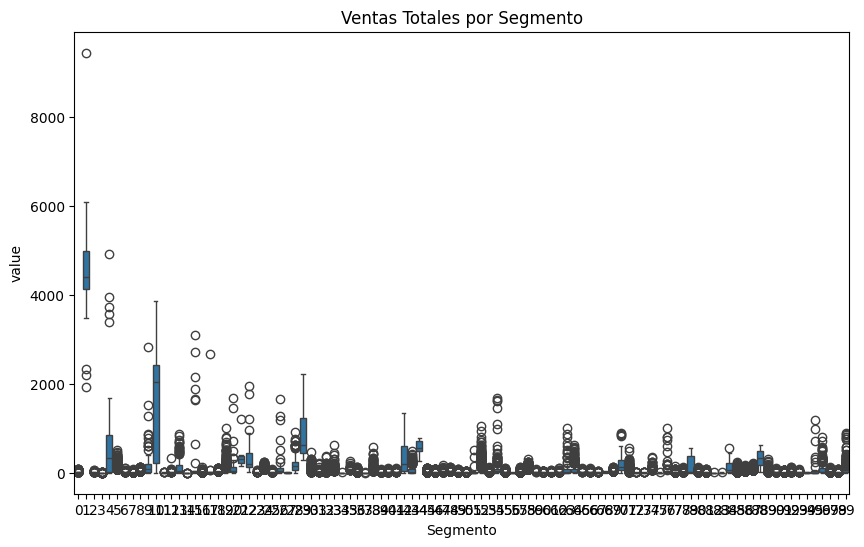

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segmento', y='value', data=data_cluster_merge)
plt.title('Ventas Totales por Segmento')
plt.show()

In [38]:

print(data_cluster_merge.groupby('Segmento')["PROVINCIA"].value_counts())
print("\n")

Segmento  PROVINCIA    
0         GUAYAS           5082
          PICHINCHA        2397
          LOS RIOS         1010
          MANABI            987
          TUNGURAHUA        733
                           ... 
98        CAÑAR              29
          LOJA               25
          SANTO DOMINGO      18
          BOLIVAR            14
99        GUAYAS            496
Name: count, Length: 960, dtype: int64




## Grafico de Tendencias De ventas

In [39]:
data_cluster_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284135 entries, 0 to 284134
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   id              284135 non-null  int64         
 1   time            284135 non-null  datetime64[ns]
 2   value           284135 non-null  float64       
 3   Segmento        284135 non-null  int32         
 4   cluster_dbscan  284135 non-null  int64         
 5   fcluster        284135 non-null  int32         
 6   cluster_agg     284135 non-null  int64         
 7   id_comercio     284135 non-null  int64         
 8   FECHA INGRESO   284135 non-null  datetime64[ns]
 9   PROVINCIA       284135 non-null  object        
dtypes: datetime64[ns](2), float64(1), int32(2), int64(4), object(1)
memory usage: 19.5+ MB


### Grafico de tendencias Por Cluster

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month


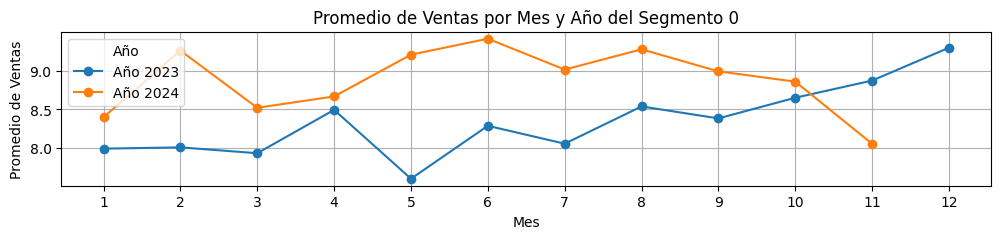

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month


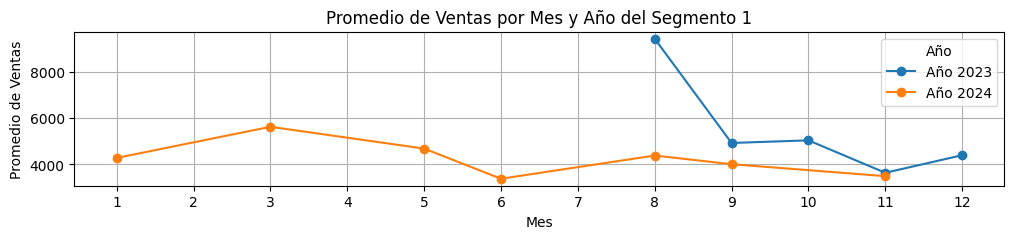

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month


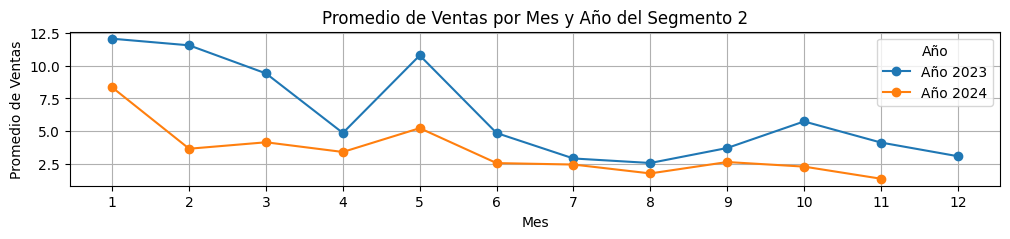

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month


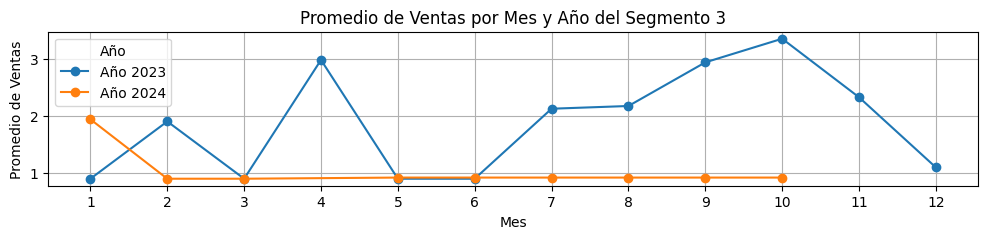

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1667405829.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month


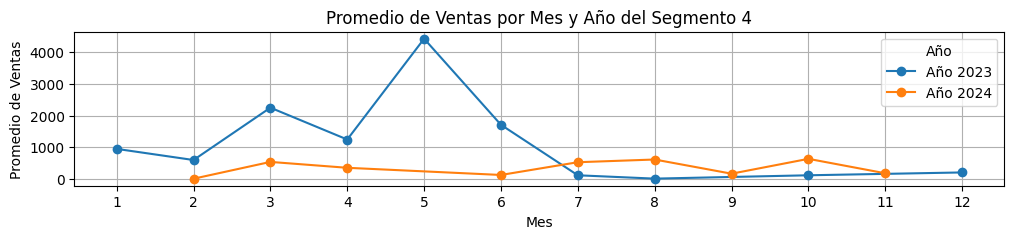

In [40]:
## GRAFICO DE VENTAS TOTALES POR SEGMENTO
for i in range(0,5):
    #print(i)
    comercios_cluster_groupby_index = data_cluster_merge[data_cluster_merge["Segmento"]==i]
    #print(comercios_cluster_groupby_index.head())

    comercios_cluster_groupby_index["Año"] = comercios_cluster_groupby_index["time"].dt.year
    comercios_cluster_groupby_index["Mes"] = comercios_cluster_groupby_index["time"].dt.month

    VentasMensualesCluster = comercios_cluster_groupby_index.groupby(["Año", "Mes"])["value"].mean().reset_index()
    VentasMensualesCluster

    plt.figure(figsize=(12, 2))

    for año in VentasMensualesCluster["Año"].unique():
        subset = VentasMensualesCluster[VentasMensualesCluster["Año"] == año]
        plt.plot(subset["Mes"], subset["value"], marker='o', linestyle='-', label=f"Año {año}")

    plt.xlabel("Mes")
    plt.ylabel("Promedio de Ventas")
    plt.title(f"Promedio de Ventas por Mes y Año del Segmento {i}")
    plt.xticks(range(1, 13))  # Meses del 1 al 12
    plt.legend(title="Año")
    plt.grid(True)
    plt.show()

## Preparar Datos Comercios Nuevos

In [41]:
datos_despues.head()

Unnamed: 0      Fecha  id_comercio  idprovider  total_cliente  \
243149      243149 2024-05-01       139450           6           2.00   
244611      244611 2024-05-04       139443           5          61.90   
244997      244997 2024-05-04       139480          26           5.20   
245470      245470 2024-05-05       139447          26           9.40   
245516      245516 2024-05-06       139443         639          28.78   

        Ventas Totales  nTRX        id                         COMERCIO  \
243149        1.739130     1  10144527               PANADERIA EL SABOR   
244611       53.826087    27  10198548                      TORTUGACELL   
244997        4.521739     3  10198588  ECU VIDA CIUDADELA DEL EJERCITO   
245470        8.173913     8  10212780                 FARMACIA JOSELYN   
245516       28.780000     1  10231649                      TORTUGACELL   

       ESTADO FECHA INGRESO                      EJECUTIVO         medio  \
243149      1    2024-05-01  GUERRA SALAZAR RENAN MAURICIO   POS VIRTUAL   
244611      1    2024-05-01  ALARCON SANCHEZ CESAR ANTONIO  POS TERMINAL   
244997      1    2024-05-03    BRAVO CEVALLOS OSCAR MARTIN   POS VIRTUAL   
245470      1    2024-05-01     SILVA MENDEZ FAUSTO GERMAN   POS VIRTUAL   
245516      1    2024-05-01  ALARCON SANCHEZ CESAR ANTONIO  POS TERMINAL   

             REGION   PROVINCIA    CIUDAD  IDEJECUTIVO FechaIngreso  \
243149  R1 - Sierra   PICHINCHA     QUITO          370   2024-05-01   
244611   R2 - COSTA      GUAYAS  NARANJAL          263   2024-05-01   
244997  R1 - Sierra   PICHINCHA     QUITO          262   2024-05-03   
245470  R1 - Sierra  TUNGURAHUA    AMBATO          289   2024-05-01   
245516   R2 - COSTA      GUAYAS  NARANJAL          263   2024-05-01   

       FechaIngresoMES  
243149         2024-05  
244611         2024-05  
244997         2024-05  
245470         2024-05  
245516         2024-05

In [42]:
data_tsfresh_new = datos_despues[["id_comercio", "Fecha", "Ventas Totales"]]

data_tsfresh_new.columns = ["id", "time", "value"]

data_tsfresh_new["time"] = pd.to_datetime(data_tsfresh_new["time"])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\202789324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tsfresh_new["time"] = pd.to_datetime(data_tsfresh_new["time"])


In [43]:
data_tsfresh_new

id       time      value
243149  139450 2024-05-01   1.739130
244611  139443 2024-05-04  53.826087
244997  139480 2024-05-04   4.521739
245470  139447 2024-05-05   8.173913
245516  139443 2024-05-06  28.780000
...        ...        ...        ...
336945  140786 2024-11-04   4.521739
336985  139735 2024-11-04  13.434783
336988  140662 2024-11-04   4.347826
336989  140516 2024-11-04  21.090000
336994  140186 2024-11-04   1.739130

[4010 rows x 3 columns]

In [44]:
features_nuevos = extract_features(
    data_tsfresh_new, 
    column_id="id", 
    column_sort="time"
)


Feature Extraction: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


In [45]:
features_nuevos_relevantes = features_nuevos[selected_features.columns]

In [46]:
features_nuevos_scaled = scaler.transform(features_nuevos_relevantes)

In [47]:
features_nuevos_scaled

array([[-2.08929898e-01, -4.83157643e-02, -3.95914191e-02, ...,
                    nan, -1.07114468e-02,  5.91763428e-01],
       [-1.49710061e-01, -7.19683216e-02, -8.01890160e-02, ...,
                    nan, -1.77562265e+00,  1.67930892e+00],
       [ 1.21862045e-01,  4.58457895e-03,  1.12652635e-03, ...,
                    nan,  2.95595650e-02,  1.72971812e+00],
       ...,
       [-2.30971463e-01, -1.42163008e-01, -1.05654781e-01, ...,
                    nan,             nan,             nan],
       [-2.30306390e-01, -8.64650503e-02, -4.32821097e-02, ...,
                    nan,             nan,             nan],
       [-2.30306390e-01, -8.64650503e-02, -4.32821097e-02, ...,
                    nan,             nan,             nan]])

In [48]:
features_nuevos_scaled = np.nan_to_num(features_nuevos_scaled, nan=0.0, posinf=0.0, neginf=0.0)


## Asignar Modelos

In [49]:
modelos = [kmeans, dbscan, agg_clustering]

modelo_seleccionado = modelos[0]

# Obtener los centroides del modelo seleccionado
centroides = modelo_seleccionado.cluster_centers_

### ASIGNAR KNN PERO POR PROXIMIDAD

In [50]:
from tslearn.metrics import dtw

asignaciones_nuevos = []

for i, serie_nueva in enumerate(features_nuevos_scaled):
    min_dist = float("inf")
    mejor_cluster = None

    
    for cluster_id, centroide in enumerate(centroides):
        distancia = dtw(serie_nueva, centroide)  
        if distancia < min_dist:
            min_dist = distancia
            mejor_cluster = cluster_id

    asignaciones_nuevos.append(mejor_cluster)

features_nuevos_relevantes["Cluste_Knn2"] = asignaciones_nuevos

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2715537667.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_nuevos_relevantes["Cluste_Knn2"] = asignaciones_nuevos


### Knn

In [51]:
clusters_nuevos = kmeans.predict(features_nuevos_scaled)
features_nuevos_relevantes["Cluste_Knn"] = clusters_nuevos

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2325565130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_nuevos_relevantes["Cluste_Knn"] = clusters_nuevos


In [52]:
features_nuevos_relevantes[["Cluste_Knn2","Cluste_Knn"]]

Cluste_Knn2  Cluste_Knn
139441            2          25
139442           32          85
139443           30          30
139444            6           6
139445           47          25
...             ...         ...
141356            6           6
141361            6           6
141362           31          31
141372            6           6
141377            6           6

[867 rows x 2 columns]

### dbscan

In [53]:
labels = dbscan.fit_predict(features_nuevos_scaled)
features_nuevos_relevantes["cluster_dbscan"] = labels

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\1550006048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_nuevos_relevantes["cluster_dbscan"] = labels


In [54]:
features_nuevos_relevantes["cluster_dbscan"].value_counts()

cluster_dbscan
-1    681
 2     76
 0     60
 1     27
 3     12
 4     11
Name: count, dtype: int64

### Fcluster

In [55]:
labels = agg_clustering.fit_predict(features_nuevos_scaled)


features_nuevos_relevantes["fcluster"] = labels

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\650649593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_nuevos_relevantes["fcluster"] = labels


In [56]:
features_nuevos_relevantes["fcluster"].value_counts()

fcluster
64    142
12     54
14     43
3      33
43     25
     ... 
52      1
63      1
61      1
51      1
67      1
Name: count, Length: 100, dtype: int64

In [57]:
features_nuevos_relevantes["Cluste_Knn"].value_counts()

Cluste_Knn
6     200
31     80
93     51
12     51
25     50
40     49
97     30
61     26
62     26
41     23
2      23
11     21
53     18
65     17
66     17
72     17
39     17
80     14
47     14
60     14
16     13
90     12
55     11
81      9
23      9
49      7
59      7
78      7
32      6
89      5
43      4
30      4
98      3
57      3
7       2
0       2
91      2
85      1
58      1
79      1
Name: count, dtype: int64

In [58]:
datosClusterDespues = data_tsfresh_new.merge(features_nuevos_relevantes[["Cluste_Knn","fcluster","cluster_dbscan","Cluste_Knn2"]], left_on="id", right_index=True)

In [59]:
datosClusterDespues.head()

id       time      value  Cluste_Knn  fcluster  cluster_dbscan  \
243149  139450 2024-05-01   1.739130          89        21              -1   
244611  139443 2024-05-04  53.826087          30         2              -1   
244997  139480 2024-05-04   4.521739          39        42              -1   
245470  139447 2024-05-05   8.173913          78         9              -1   
245516  139443 2024-05-06  28.780000          30         2              -1   

        Cluste_Knn2  
243149           89  
244611           30  
244997           23  
245470           16  
245516           30

In [60]:
data_cluster

id       time      value  Segmento  cluster_dbscan  fcluster  \
2       101806 2023-01-01   2.678571        46              -1        23   
3       113299 2023-01-01   0.892857        97              -1        41   
7        46501 2023-01-01  12.422360         8              -1        71   
8       113802 2023-01-01   2.678571         7              -1        39   
9       114653 2023-01-01   0.892857        81              -1        39   
...        ...        ...        ...       ...             ...       ...   
336995   41807 2024-11-04   4.478261        48              -1        68   
336996  117221 2024-11-04  13.930000        89              -1        48   
336997  101948 2024-11-04   6.956522        87              -1        68   
336998  121274 2024-11-04   3.478261         0              -1        23   
336999  110064 2024-11-04   2.652174        45              -1        22   

        cluster_agg  
2                 7  
3                49  
7                33  
8                28  
9                28  
...             ...  
336995           34  
336996           19  
336997           34  
336998            7  
336999           32  

[284135 rows x 7 columns]

## Grafico de Prueba Modelo

### KNN ENTRENADO

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\450540168.py:5: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  ventas_cluster = data[data["id_comercio"].isin(comercios_cluster)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\450540168.py:6: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  ventas_cluster2 = data[data["id_comercio"].isin(comercios_cluster2)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)


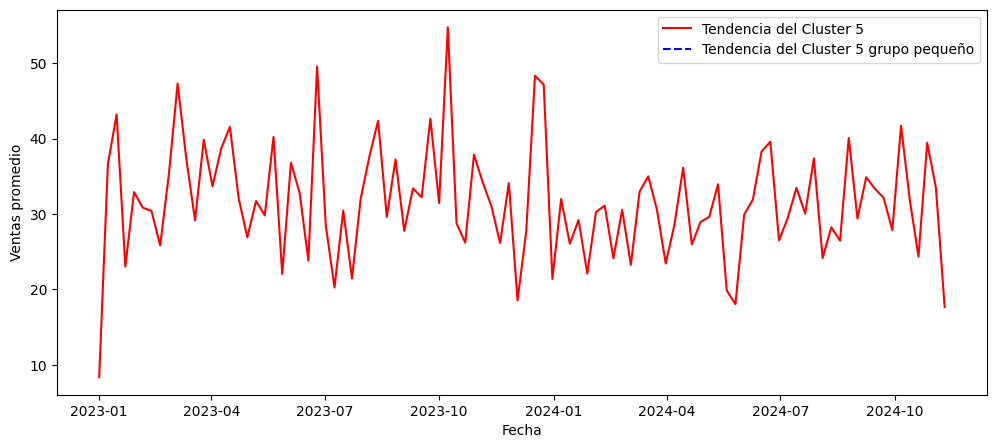

In [61]:
cluster_ejemplo = 5
comercios_cluster = data_cluster[data_cluster["Segmento"] == cluster_ejemplo]["id"]
comercios_cluster2 = datosClusterDespues[datosClusterDespues["Cluste_Knn"] == cluster_ejemplo]["id"]

ventas_cluster = data[data["id_comercio"].isin(comercios_cluster)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)
ventas_cluster2 = data[data["id_comercio"].isin(comercios_cluster2)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)

plt.figure(figsize=(12, 5))
plt.plot(ventas_cluster.index, ventas_cluster, label=f"Tendencia del Cluster {cluster_ejemplo}",color='red')
plt.plot(ventas_cluster2.index, ventas_cluster2,color='blue',linestyle='dashed', label=f"Tendencia del Cluster {cluster_ejemplo} grupo pequeño")
plt.xlabel("Fecha")
plt.ylabel("Ventas promedio")
plt.legend()
plt.show()


In [62]:
datosClusterDespues=datosClusterDespues.rename(columns={"Cluste_Knn2":"Segmento"})
datosClusterDespues

id       time      value  Cluste_Knn  fcluster  cluster_dbscan  \
243149  139450 2024-05-01   1.739130          89        21              -1   
244611  139443 2024-05-04  53.826087          30         2              -1   
244997  139480 2024-05-04   4.521739          39        42              -1   
245470  139447 2024-05-05   8.173913          78         9              -1   
245516  139443 2024-05-06  28.780000          30         2              -1   
...        ...        ...        ...         ...       ...             ...   
336945  140786 2024-11-04   4.521739           6        64               2   
336985  139735 2024-11-04  13.434783          66        33              -1   
336988  140662 2024-11-04   4.347826          93         8              -1   
336989  140516 2024-11-04  21.090000          25        42              -1   
336994  140186 2024-11-04   1.739130          78        85              -1   

        Segmento  
243149        89  
244611        30  
244997        23  
245470        16  
245516        30  
...          ...  
336945         6  
336985        66  
336988        93  
336989        66  
336994        78  

[4010 rows x 7 columns]

### KNN Por proximidad (Mejores Resultado)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2431728375.py:5: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  ventas_cluster = data[data["id_comercio"].isin(comercios_cluster)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2431728375.py:6: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  ventas_cluster2 = data[data["id_comercio"].isin(comercios_cluster2)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)


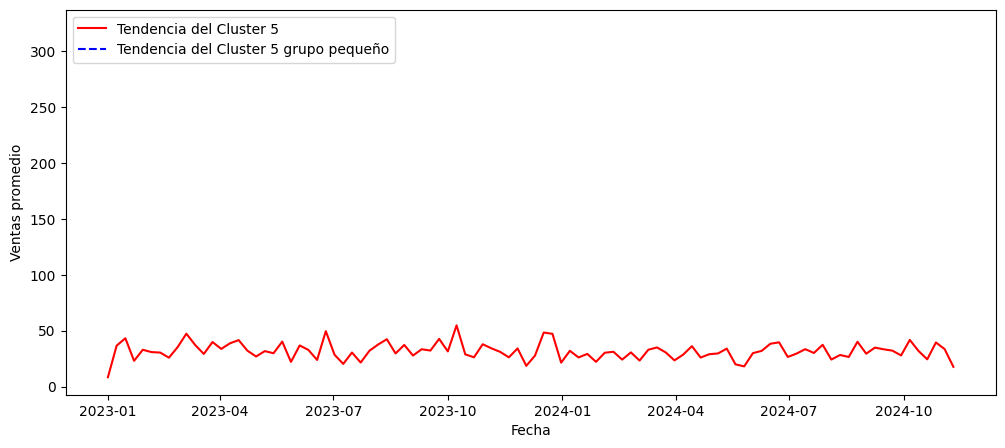

In [63]:
cluster_ejemplo = 5
comercios_cluster = data_cluster[data_cluster["Segmento"] == cluster_ejemplo]["id"]
comercios_cluster2 = datosClusterDespues[datosClusterDespues["Segmento"] == cluster_ejemplo]["id"]

ventas_cluster = data[data["id_comercio"].isin(comercios_cluster)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)
ventas_cluster2 = data[data["id_comercio"].isin(comercios_cluster2)].groupby(pd.Grouper(key="Fecha",freq="w"))["Ventas Totales"].mean().fillna(0)

plt.figure(figsize=(12, 5))
plt.plot(ventas_cluster.index, ventas_cluster, label=f"Tendencia del Cluster {cluster_ejemplo}",color='red')
plt.plot(ventas_cluster2.index, ventas_cluster2,color='blue',linestyle='dashed', label=f"Tendencia del Cluster {cluster_ejemplo} grupo pequeño")
plt.xlabel("Fecha")
plt.ylabel("Ventas promedio")
plt.legend()
plt.show()


## Entrenamiento de modelo predictivo de venta

### Preparacion de Datos de datos Menores

In [64]:
datos_mensuales_menor = data_cluster.groupby([data_cluster['time'].dt.to_period('M'), 'id','Segmento']).agg(
    Ventas_Mensuales=('value', 'sum')
).reset_index()
datos_mensuales_menor

time      id  Segmento  Ventas_Mensuales
0       2023-01       3        22        652.223214
1       2023-01       6        80          9.821429
2       2023-01       8        39          9.821429
3       2023-01      11        16         11.607143
4       2023-01      16        78         30.357143
...         ...     ...       ...               ...
132652  2024-11  139402        53          6.389414
132653  2024-11  139414        97          0.869565
132654  2024-11  139416        80          2.608696
132655  2024-11  139423        23          1.826087
132656  2024-11  139434        58         74.478261

[132657 rows x 4 columns]

In [65]:
datos_mensuales_menor['time'] = datos_mensuales_menor['time'].dt.to_timestamp()
datos_mensuales_menor

time      id  Segmento  Ventas_Mensuales
0      2023-01-01       3        22        652.223214
1      2023-01-01       6        80          9.821429
2      2023-01-01       8        39          9.821429
3      2023-01-01      11        16         11.607143
4      2023-01-01      16        78         30.357143
...           ...     ...       ...               ...
132652 2024-11-01  139402        53          6.389414
132653 2024-11-01  139414        97          0.869565
132654 2024-11-01  139416        80          2.608696
132655 2024-11-01  139423        23          1.826087
132656 2024-11-01  139434        58         74.478261

[132657 rows x 4 columns]

### Entrenamiento del Modelo

In [66]:
predicciones = []


for segmento in datos_mensuales_menor["Segmento"].unique():
    datos_segmento = datos_mensuales_menor[datos_mensuales_menor["Segmento"] == segmento]
    
    datos_segmento["Mes"] = datos_segmento["time"].dt.month + (datos_segmento["time"].dt.year - 2023) * 12

    X = datos_segmento[["Mes"]]
    y = datos_segmento["Ventas_Mensuales"]
    
    modelo = LinearRegression()
    modelo.fit(X, y)

   
    X_pred = np.array([[23], [24]])  
    predicciones_ventas = modelo.predict(X_pred)

   
    predicciones.append({
        "Segmento": segmento,
        "2024-11": predicciones_ventas[0],
        "2024-12": predicciones_ventas[1]
    })


predicciones_df = pd.DataFrame(predicciones)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2565881854.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_segmento["Mes"] = datos_segmento["time"].dt.month + (datos_segmento["time"].dt.year - 2023) * 12
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2565881854.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

### Predicciones

In [67]:
predicciones_df

Segmento      2024-11      2024-12
0         22  2256.650250  2341.124453
1         80     3.105565     2.702028
2         39     8.007312     8.179414
3         16    13.539254    13.887075
4         78    12.237422    12.099791
..       ...          ...          ...
95        21   324.062556   294.596472
96         1  5324.207391  5101.074442
97        84   413.114232   451.505207
98        37     1.194063     1.112184
99        44  1955.740000  2203.660000

[100 rows x 3 columns]

In [68]:
df_transformado = predicciones_df.melt(
    id_vars=["Segmento"],  # Mantener esta columna fija
    var_name="time",       # Renombrar la columna para las fechas
    value_name="Ventas_Mensuales"  # Renombrar la columna para los valores
)

In [69]:
df_transformado["time"] = pd.to_datetime(df_transformado["time"])
df_transformado["time"] = df_transformado["time"].dt.to_period('M')
df_transformado

Segmento     time  Ventas_Mensuales
0          22  2024-11       2256.650250
1          80  2024-11          3.105565
2          39  2024-11          8.007312
3          16  2024-11         13.539254
4          78  2024-11         12.237422
..        ...      ...               ...
195        21  2024-12        294.596472
196         1  2024-12       5101.074442
197        84  2024-12        451.505207
198        37  2024-12          1.112184
199        44  2024-12       2203.660000

[200 rows x 3 columns]

In [70]:
datos_mensuales = datosClusterDespues.groupby([datosClusterDespues['time'].dt.to_period('M'),'Segmento']).agg(
    Ventas_Mensuales=('value', 'mean')
).reset_index()
datos_mensuales

time  Segmento  Ventas_Mensuales
0    2024-05         2          9.953826
1    2024-05         6         20.090000
2    2024-05        11          1.804348
3    2024-05        16          9.956522
4    2024-05        23          4.991304
..       ...       ...               ...
245  2024-11        84          2.695652
246  2024-11        89          8.017958
247  2024-11        90          6.478261
248  2024-11        91         12.913043
249  2024-11        93          5.596838

[250 rows x 3 columns]

In [71]:
datos_mensuales[datos_mensuales["Segmento"]==1]

Empty DataFrame
Columns: [time, Segmento, Ventas_Mensuales]
Index: []

In [72]:
datos_mensuales_menor

time      id  Segmento  Ventas_Mensuales
0      2023-01-01       3        22        652.223214
1      2023-01-01       6        80          9.821429
2      2023-01-01       8        39          9.821429
3      2023-01-01      11        16         11.607143
4      2023-01-01      16        78         30.357143
...           ...     ...       ...               ...
132652 2024-11-01  139402        53          6.389414
132653 2024-11-01  139414        97          0.869565
132654 2024-11-01  139416        80          2.608696
132655 2024-11-01  139423        23          1.826087
132656 2024-11-01  139434        58         74.478261

[132657 rows x 4 columns]

### Resultados

Del lado izquierdo se encuentran las predicciones

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

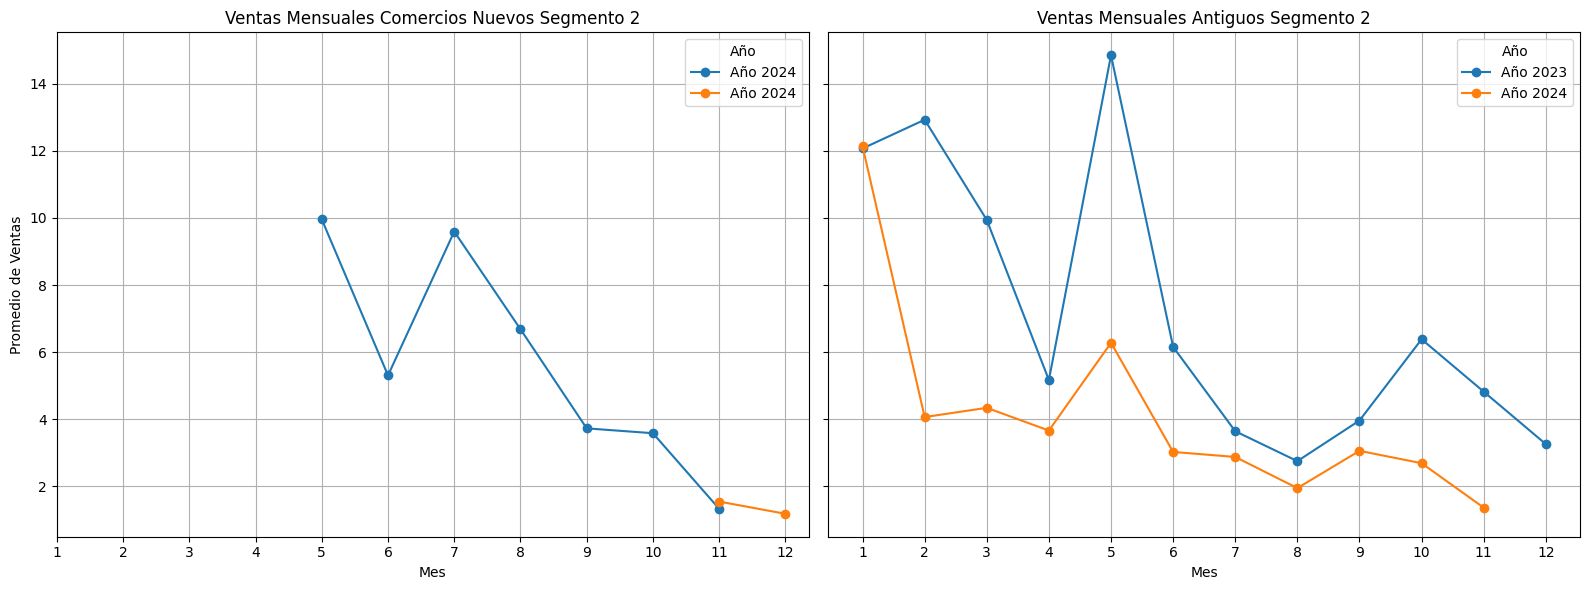

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

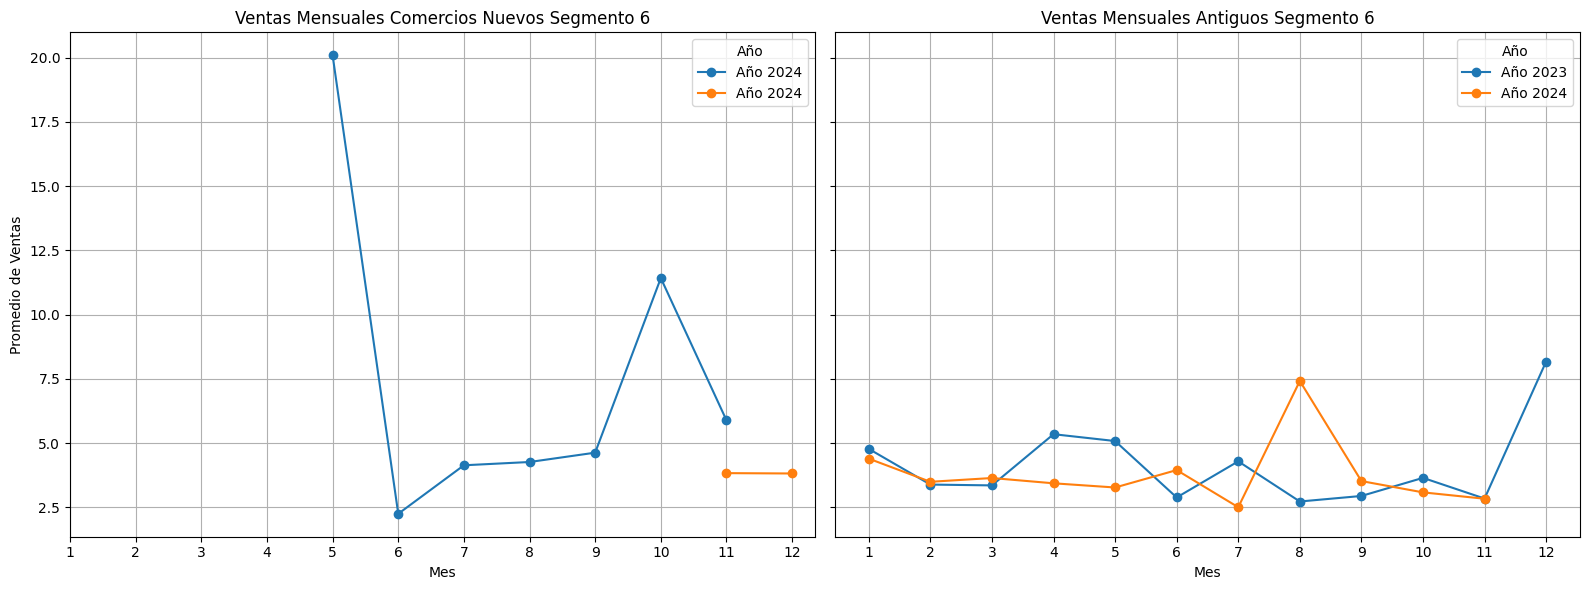

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

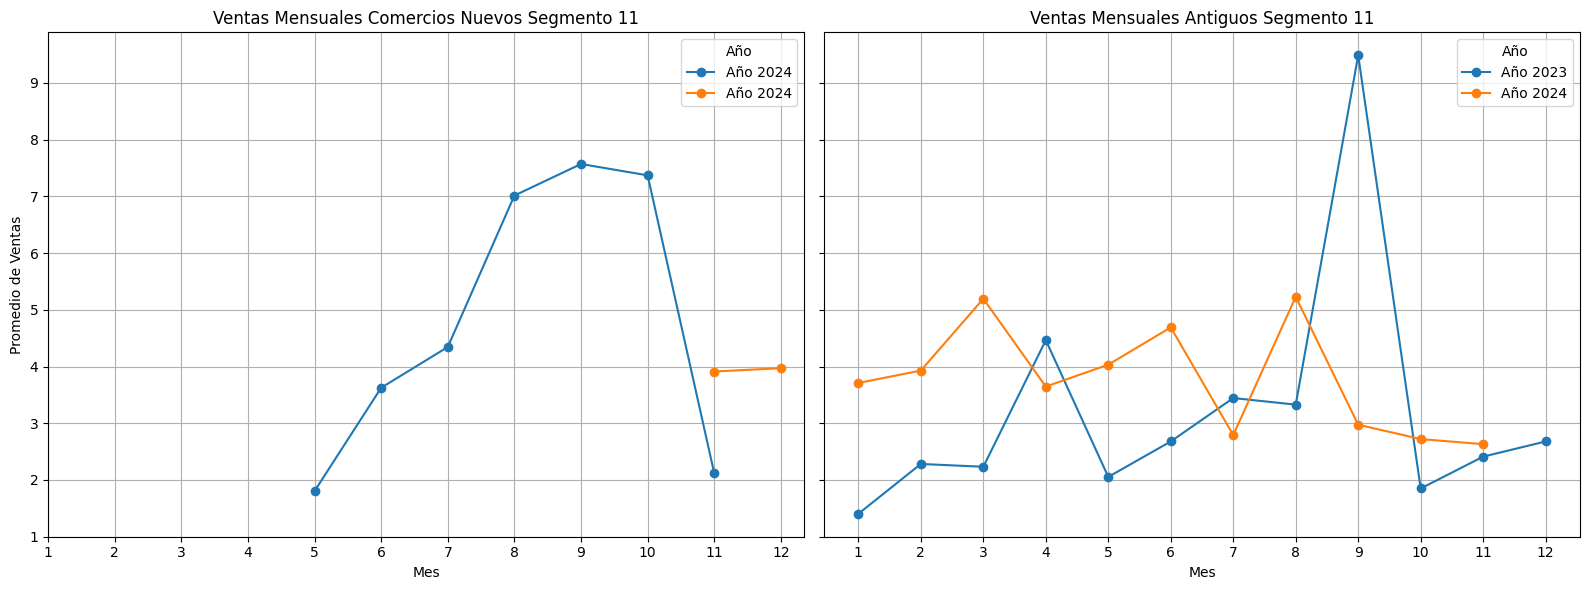

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

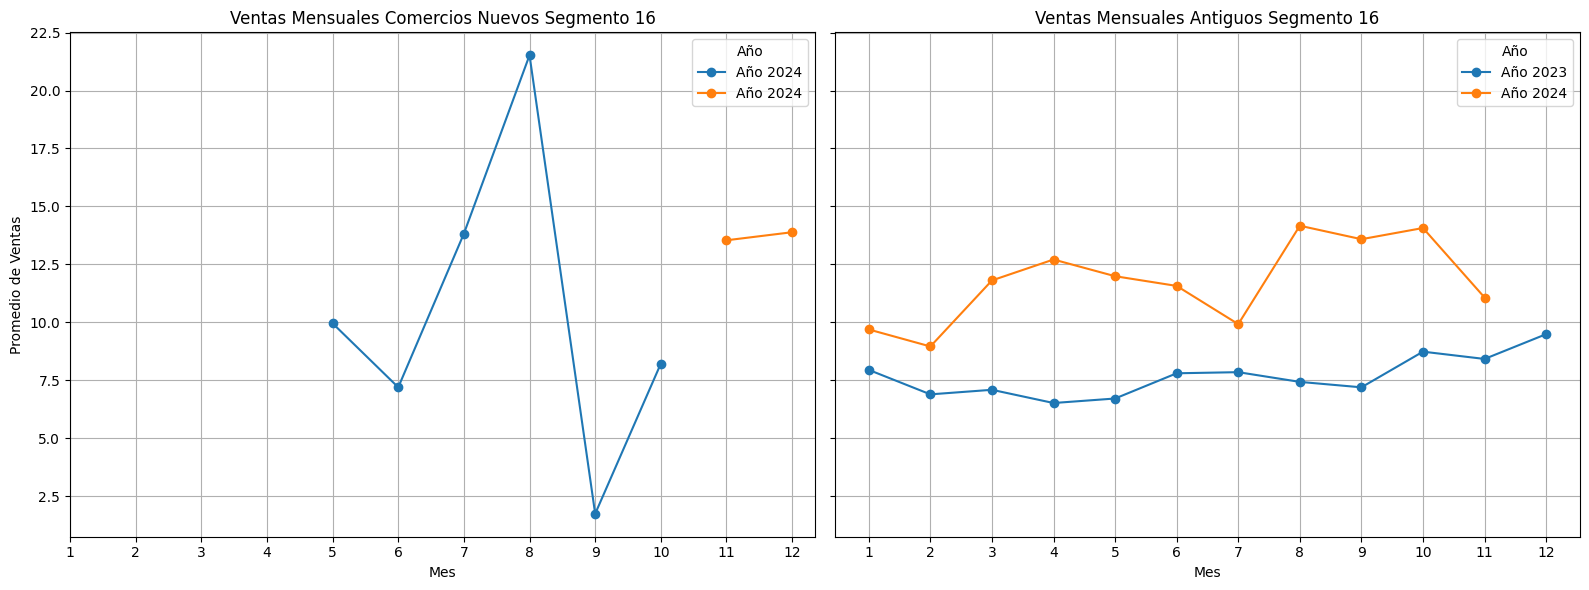

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

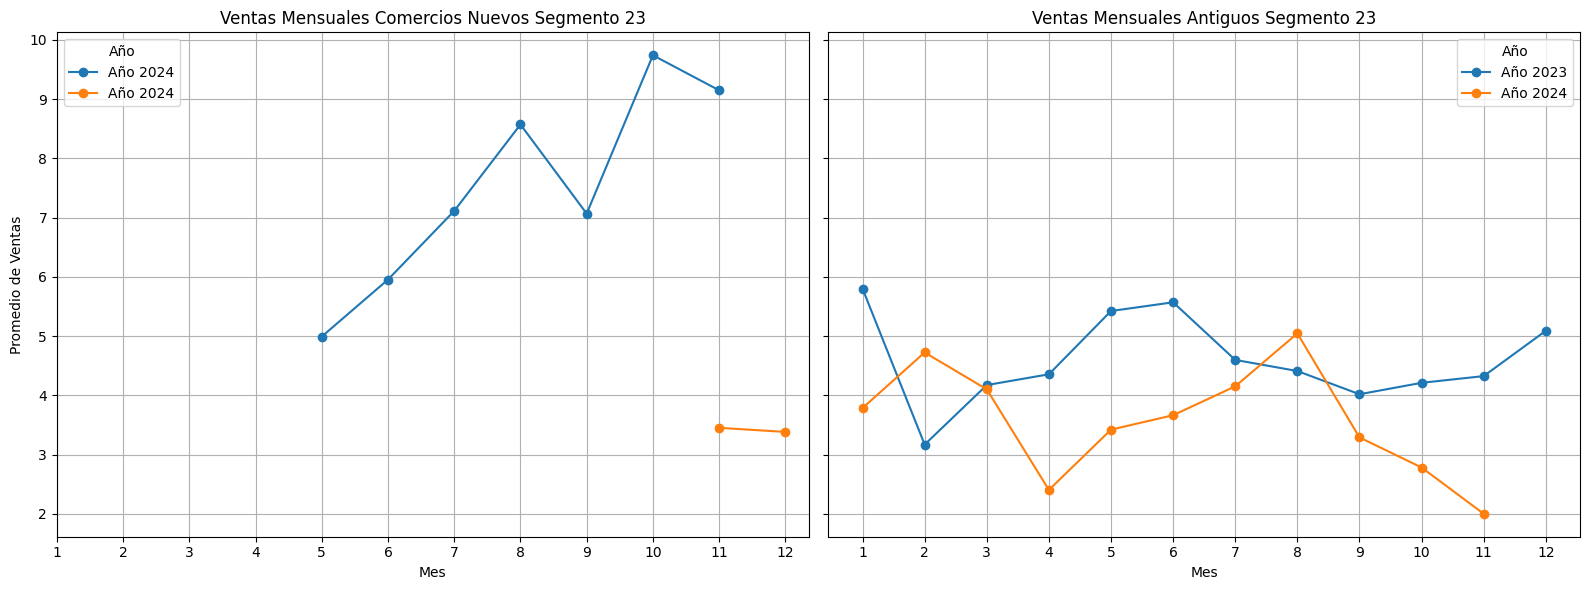

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

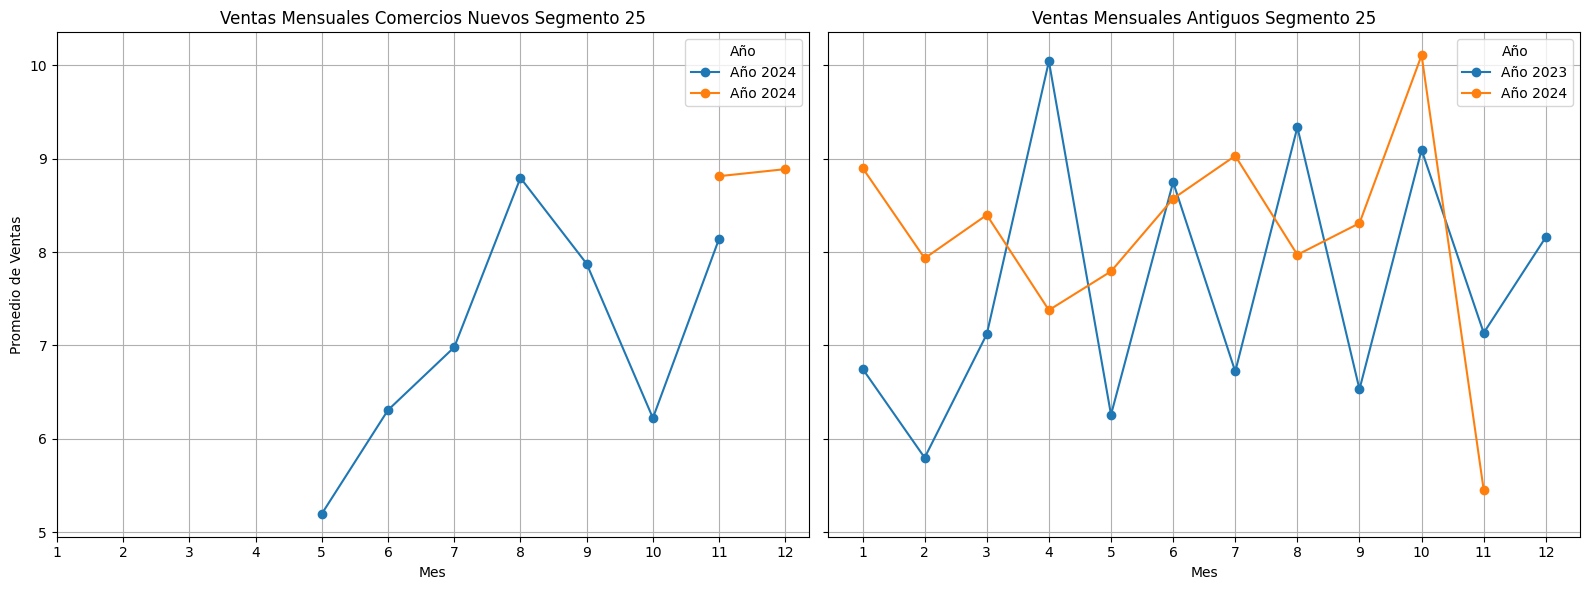

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

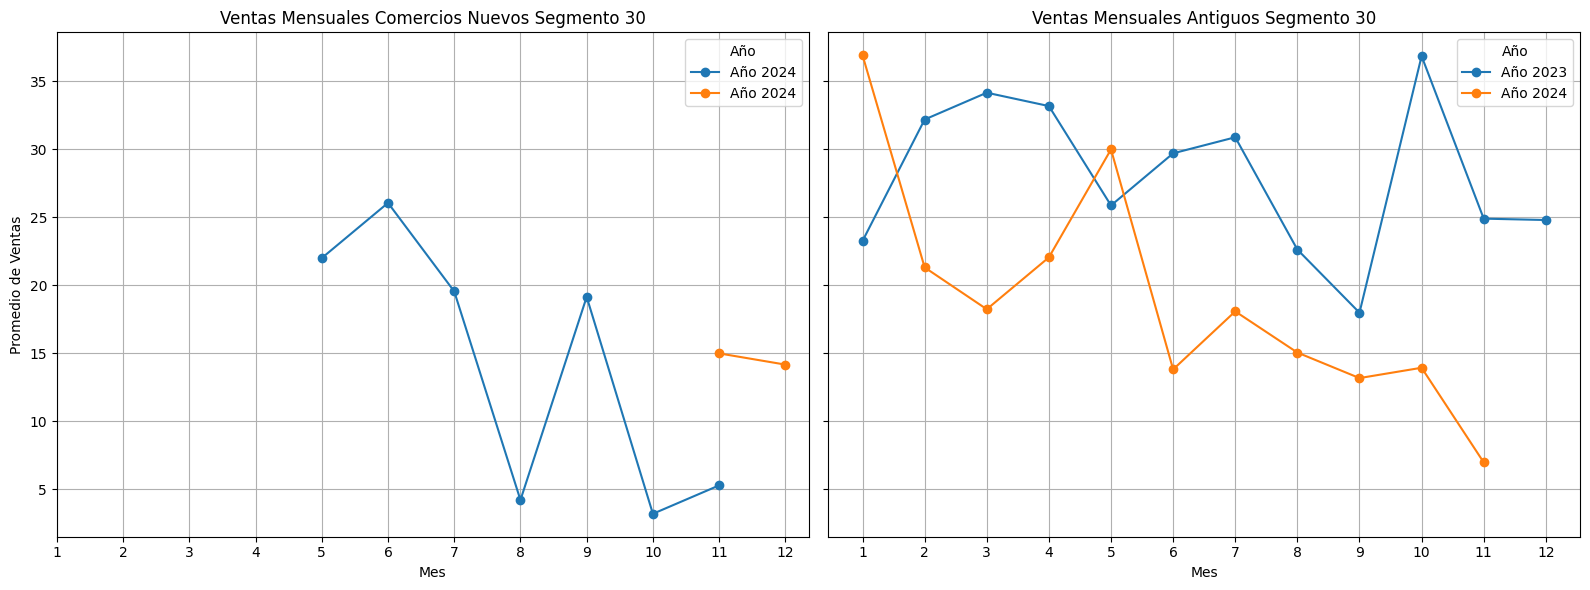

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

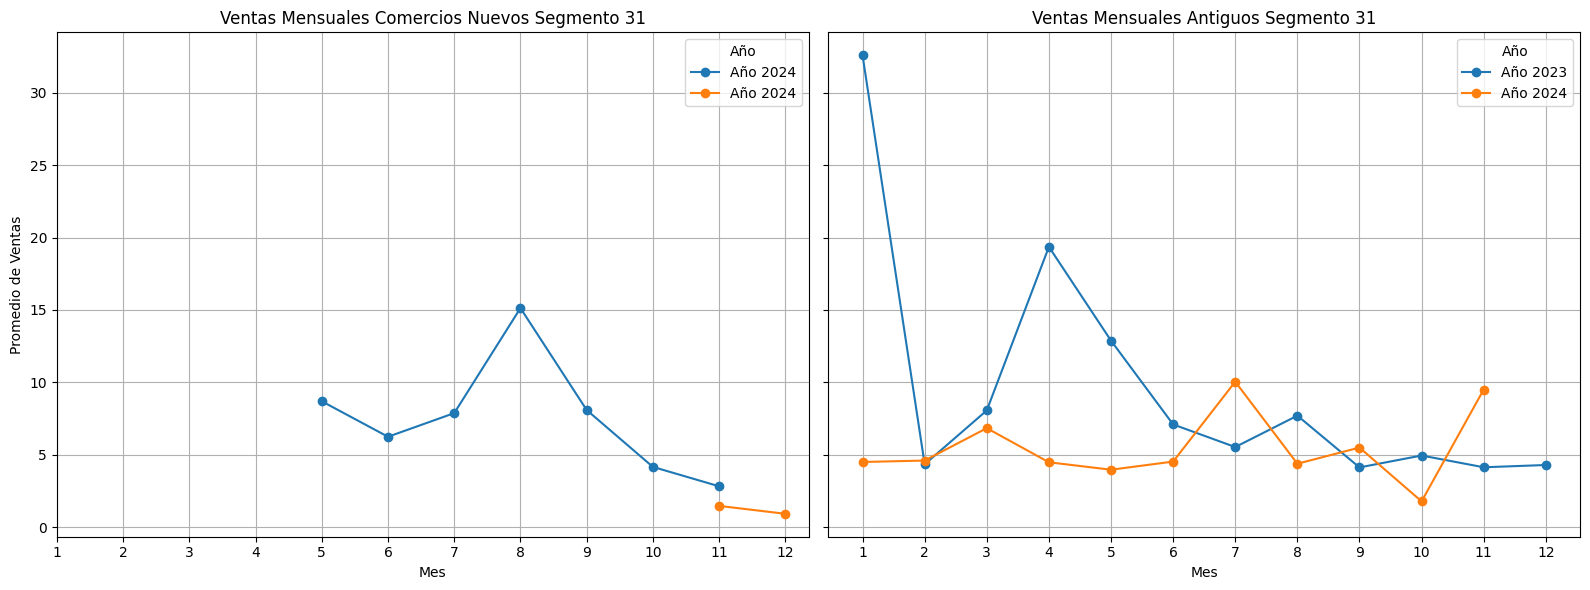

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

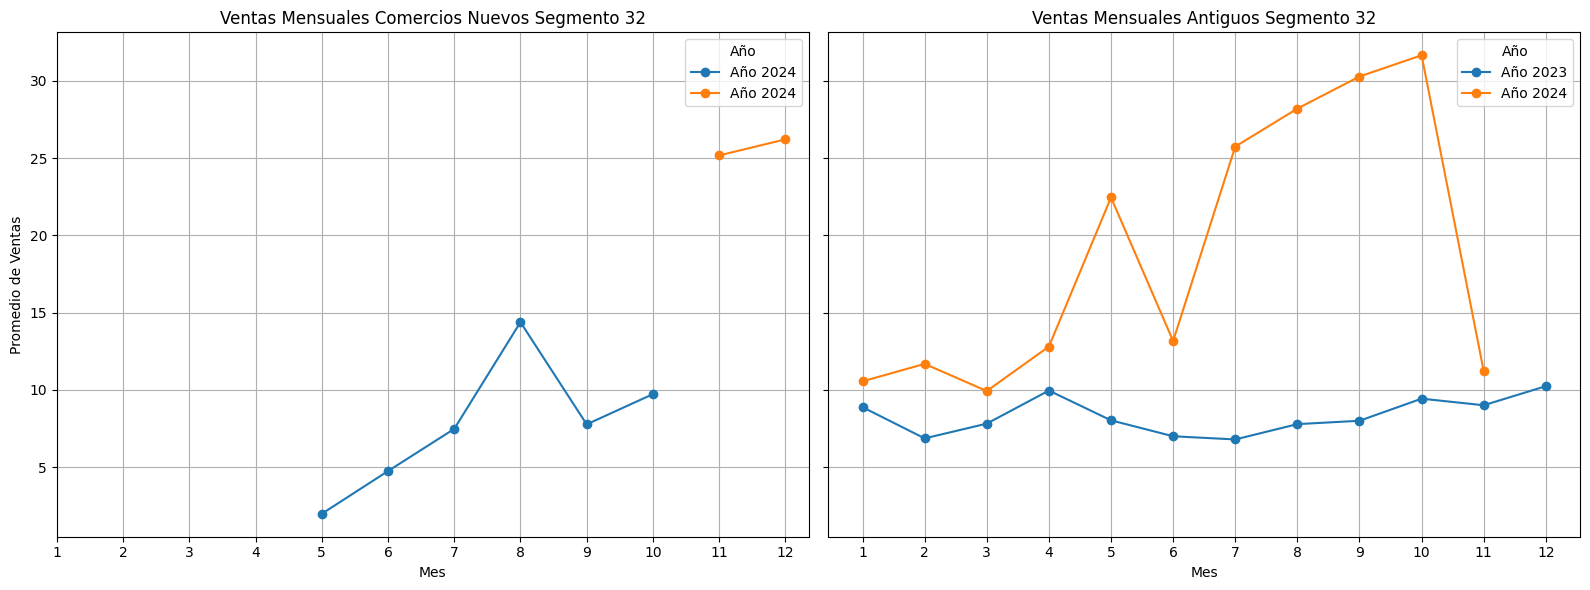

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

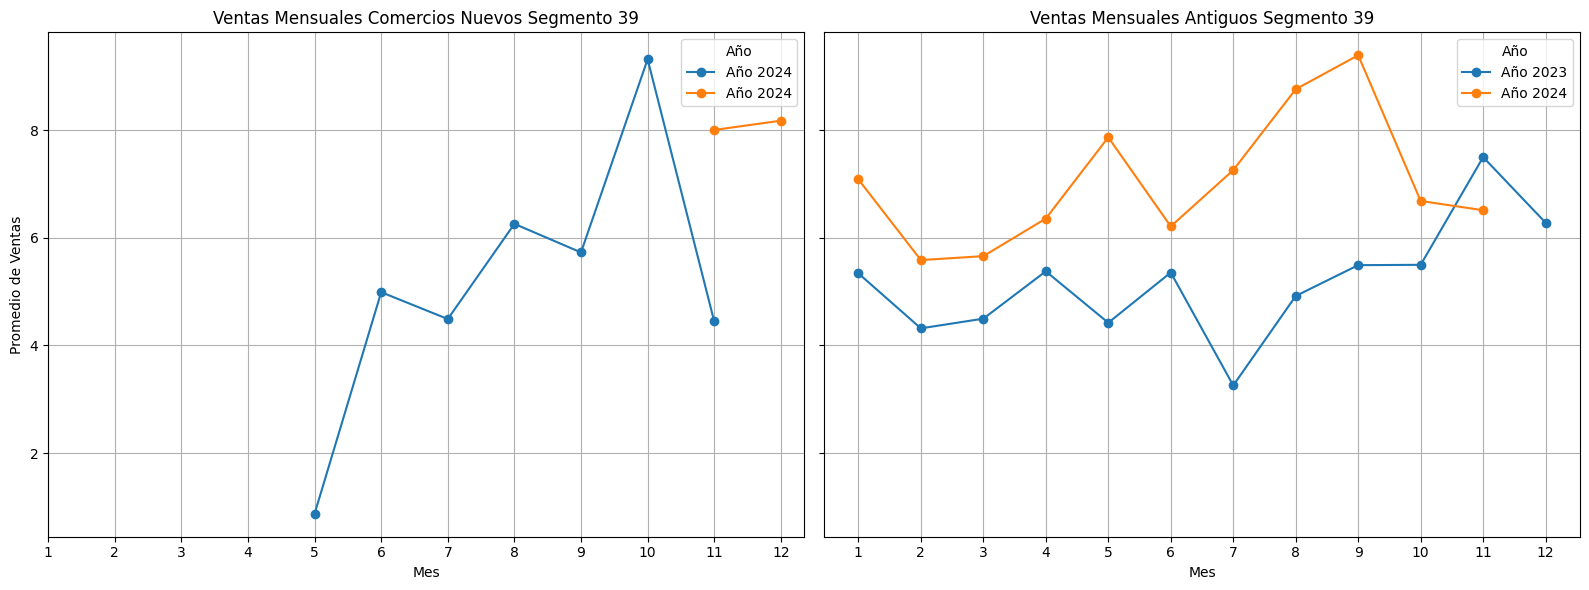

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

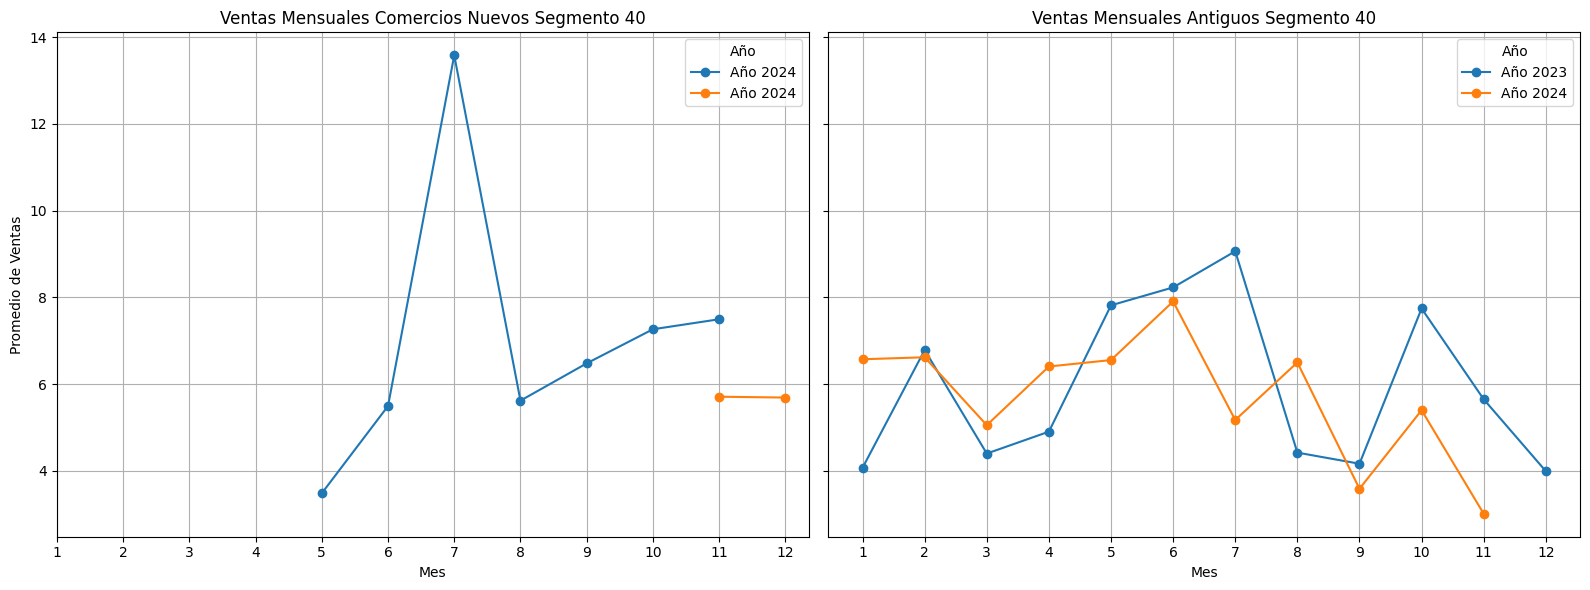

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

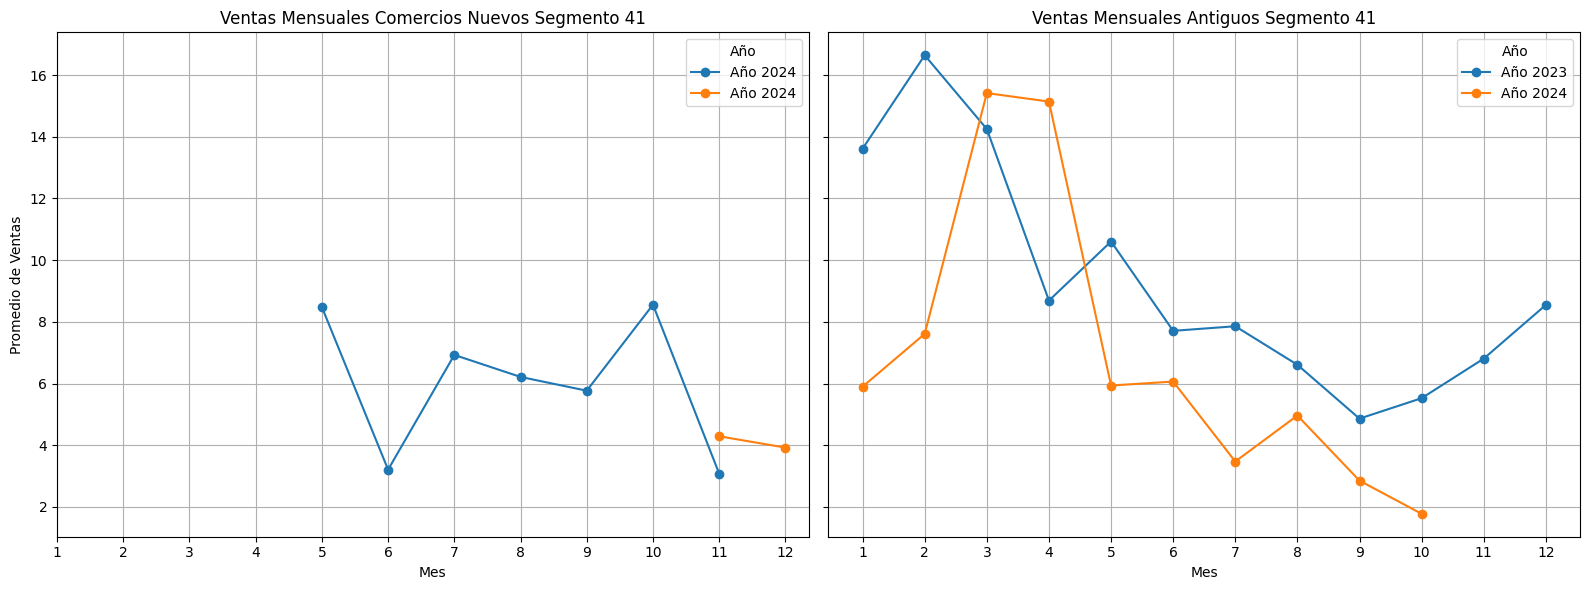

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

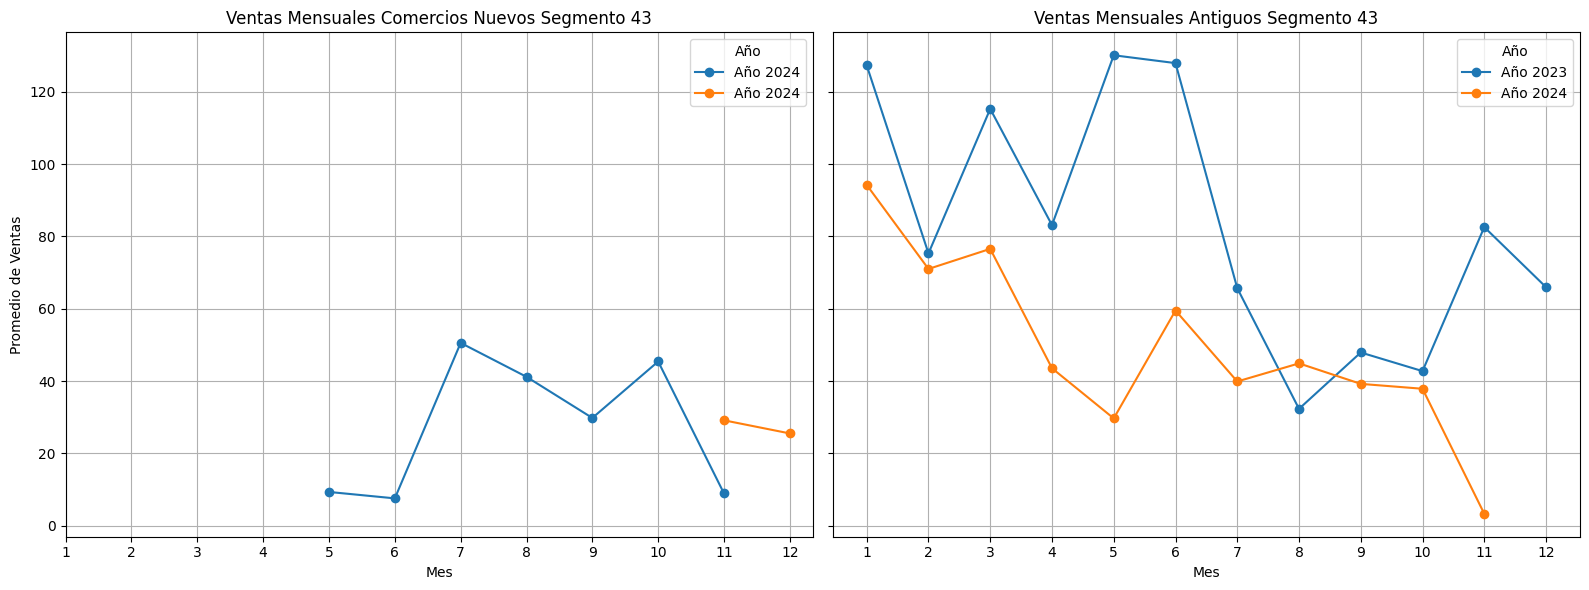

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

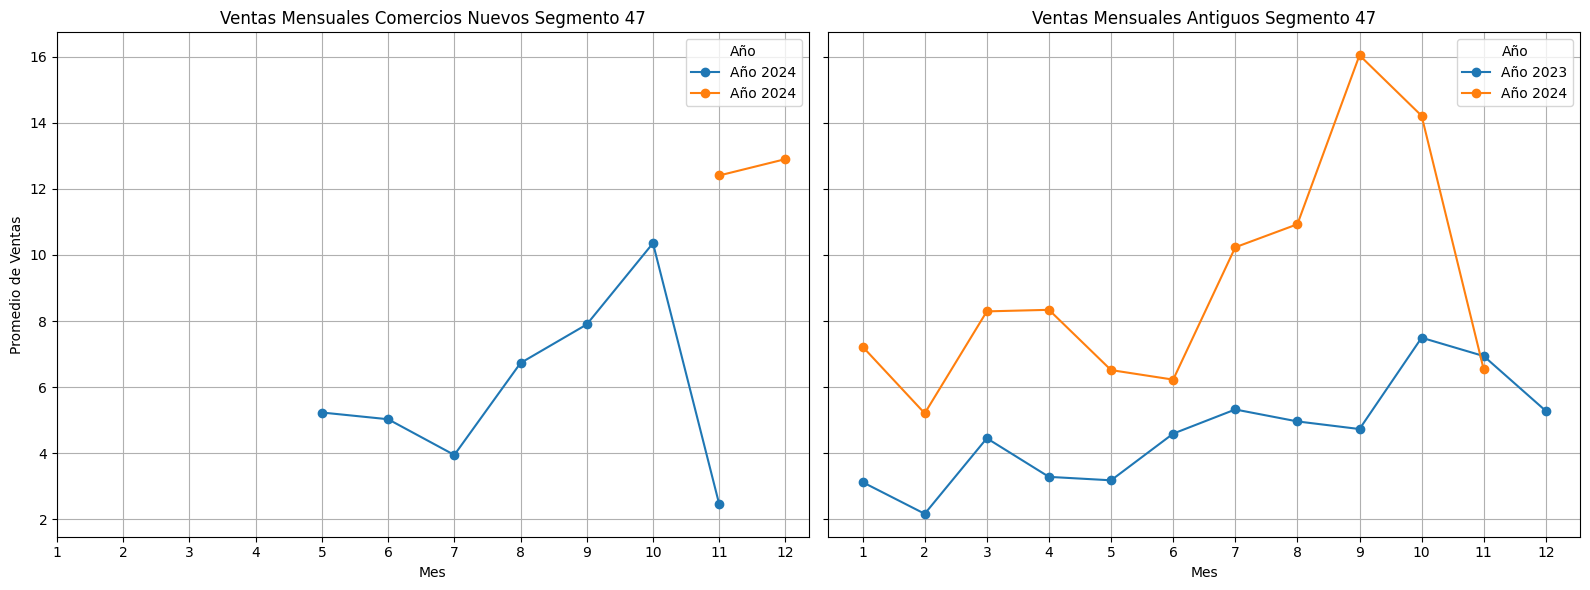

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

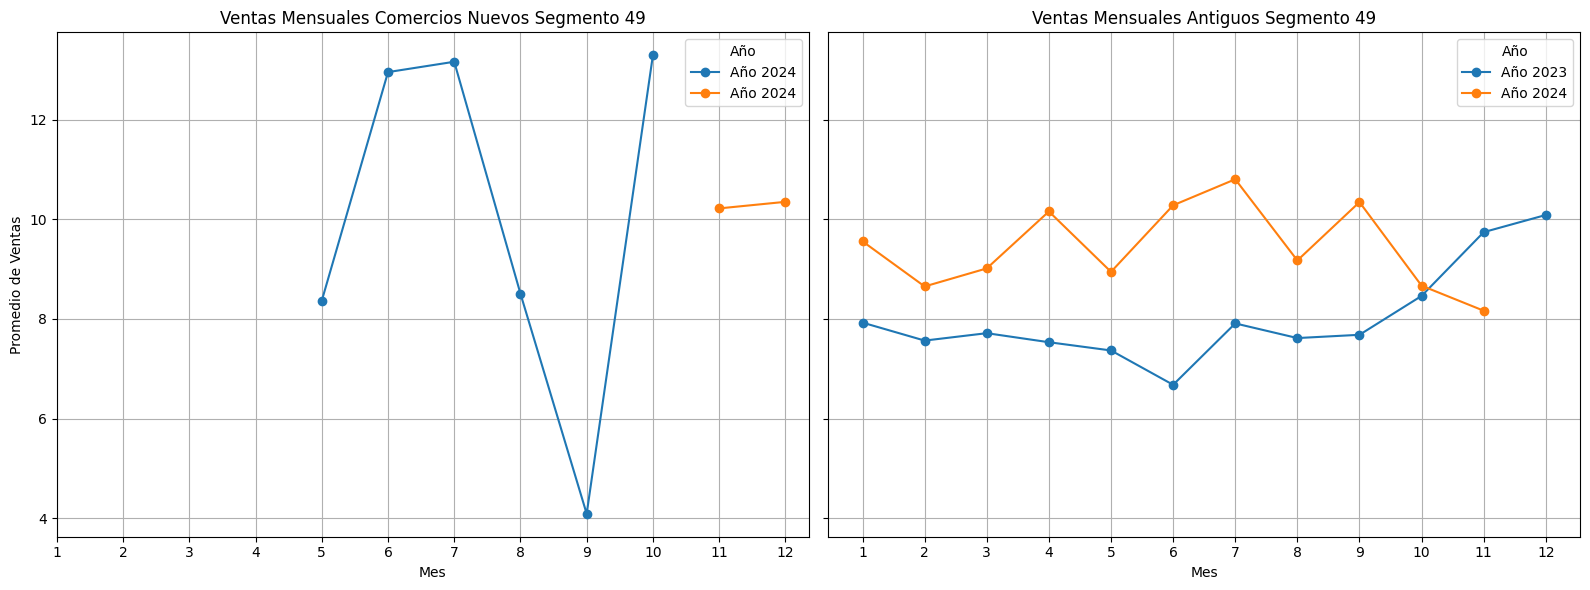

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

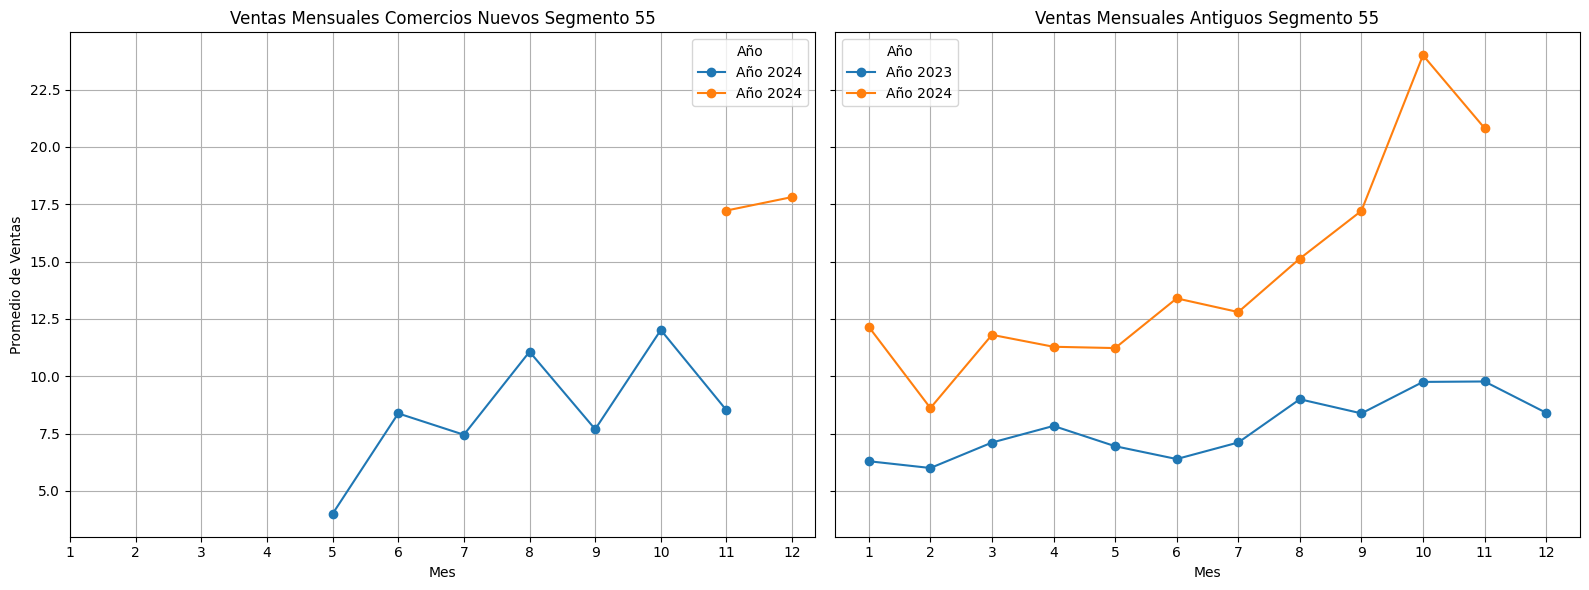

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

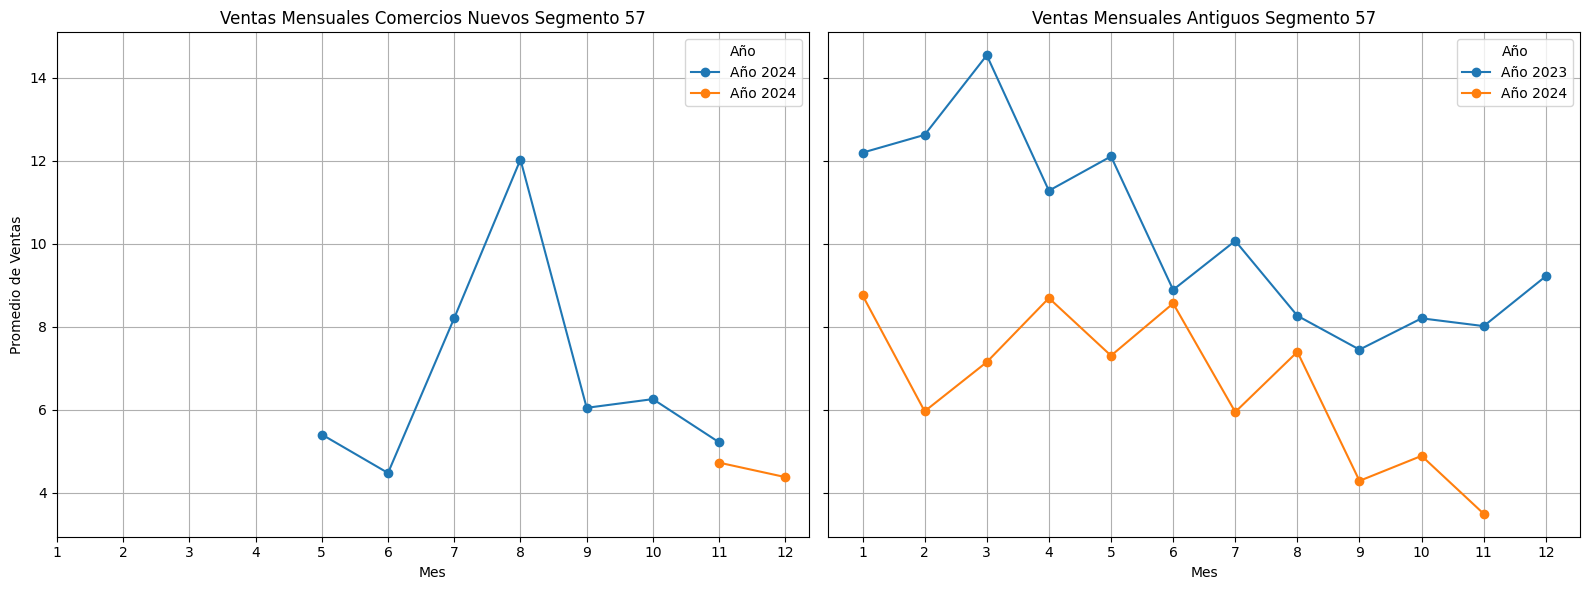

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

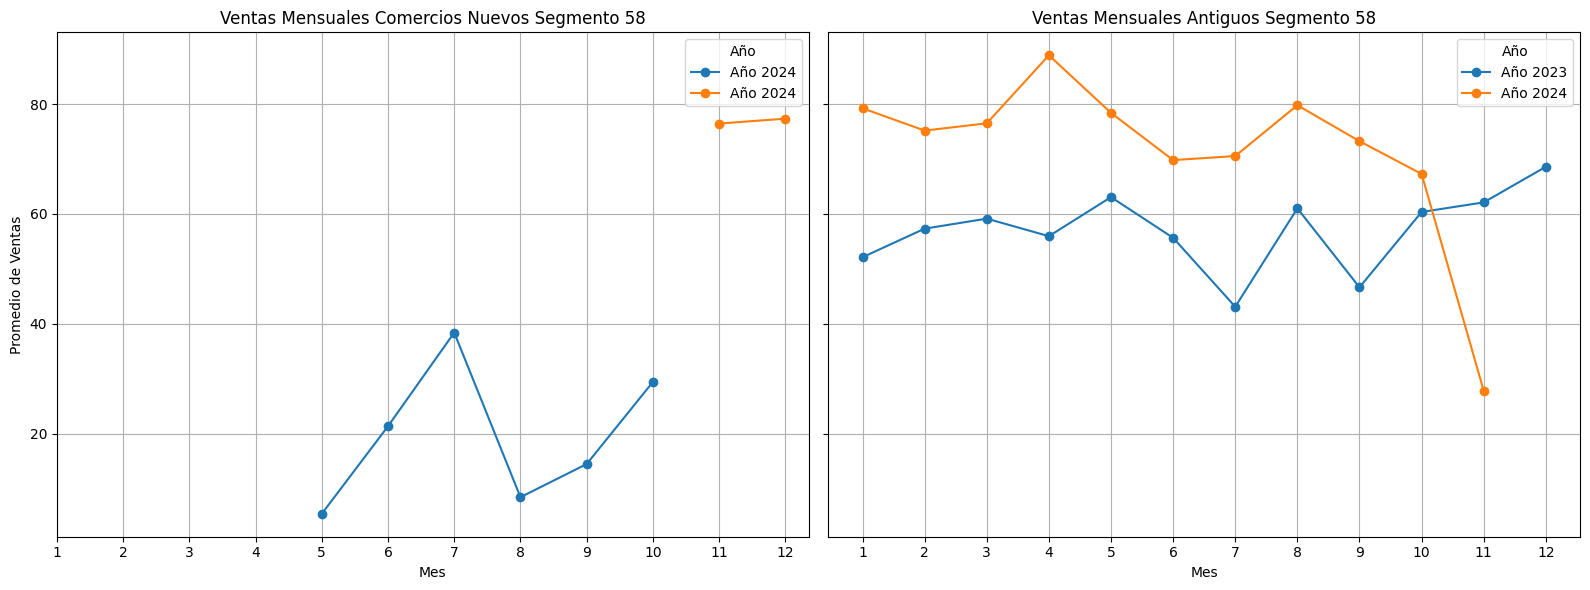

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

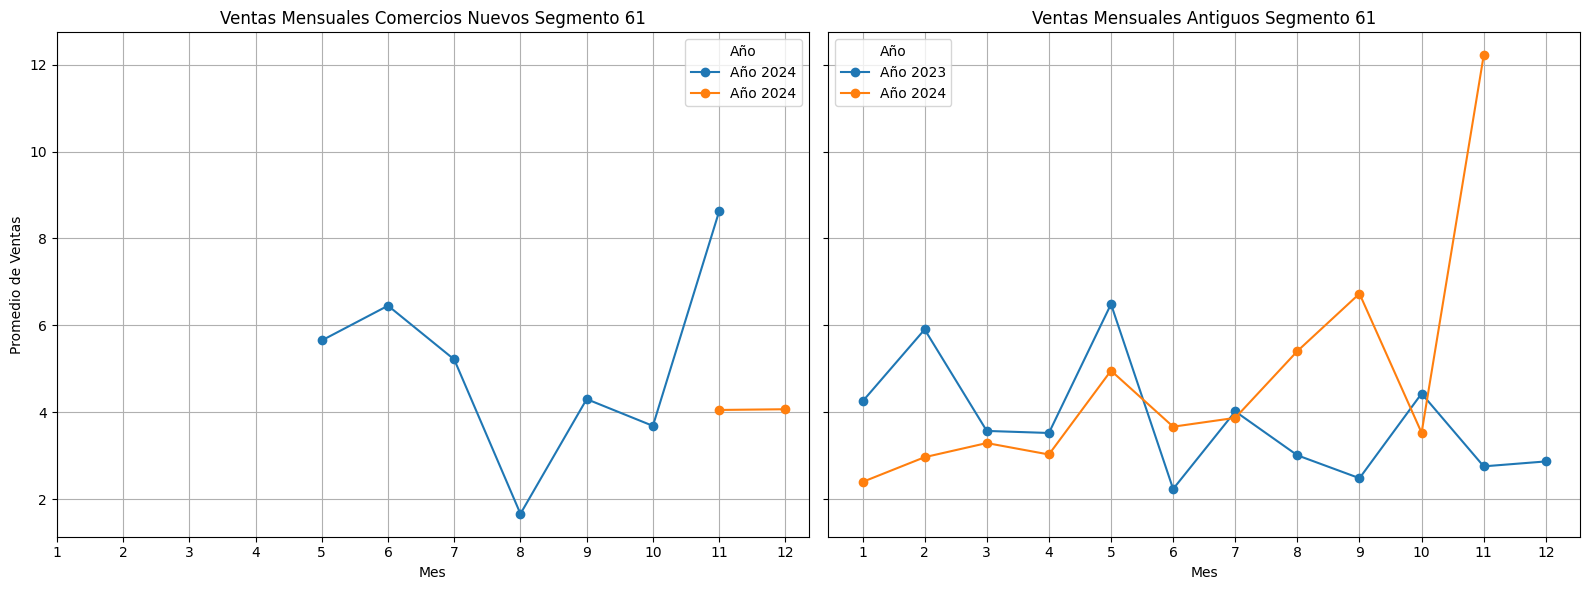

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

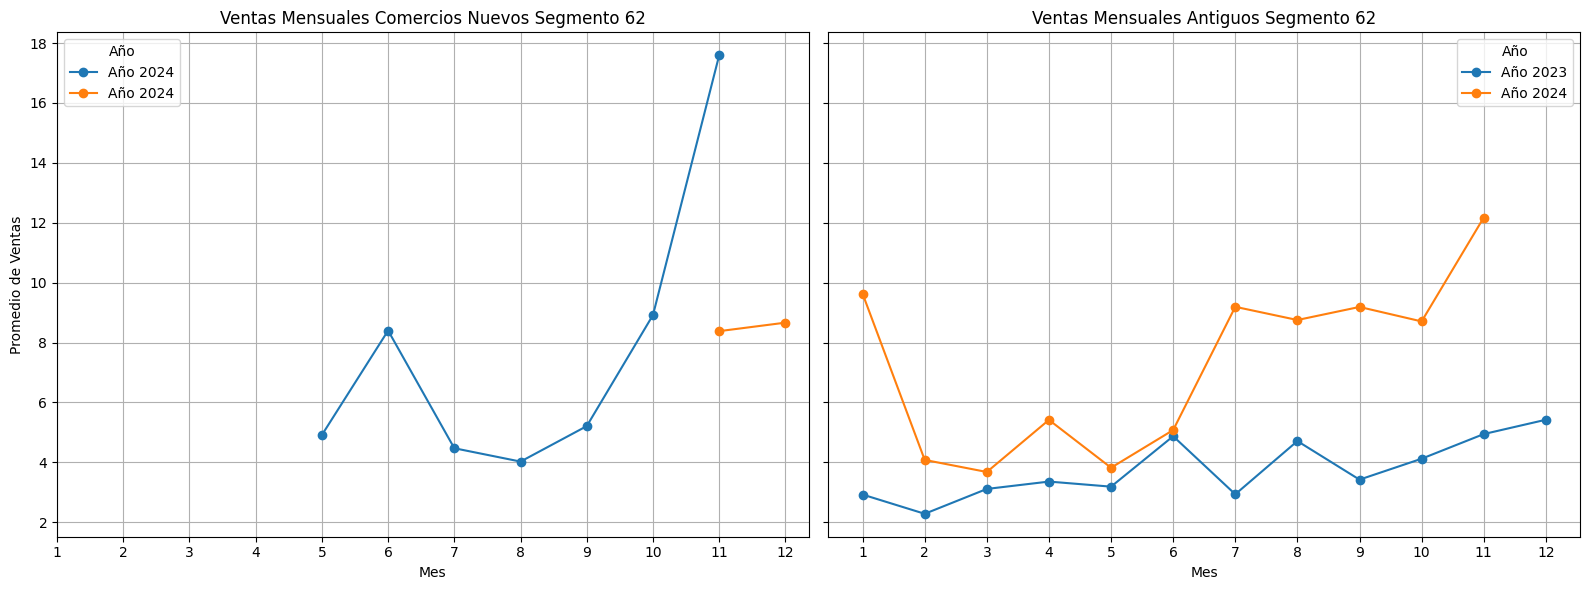

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

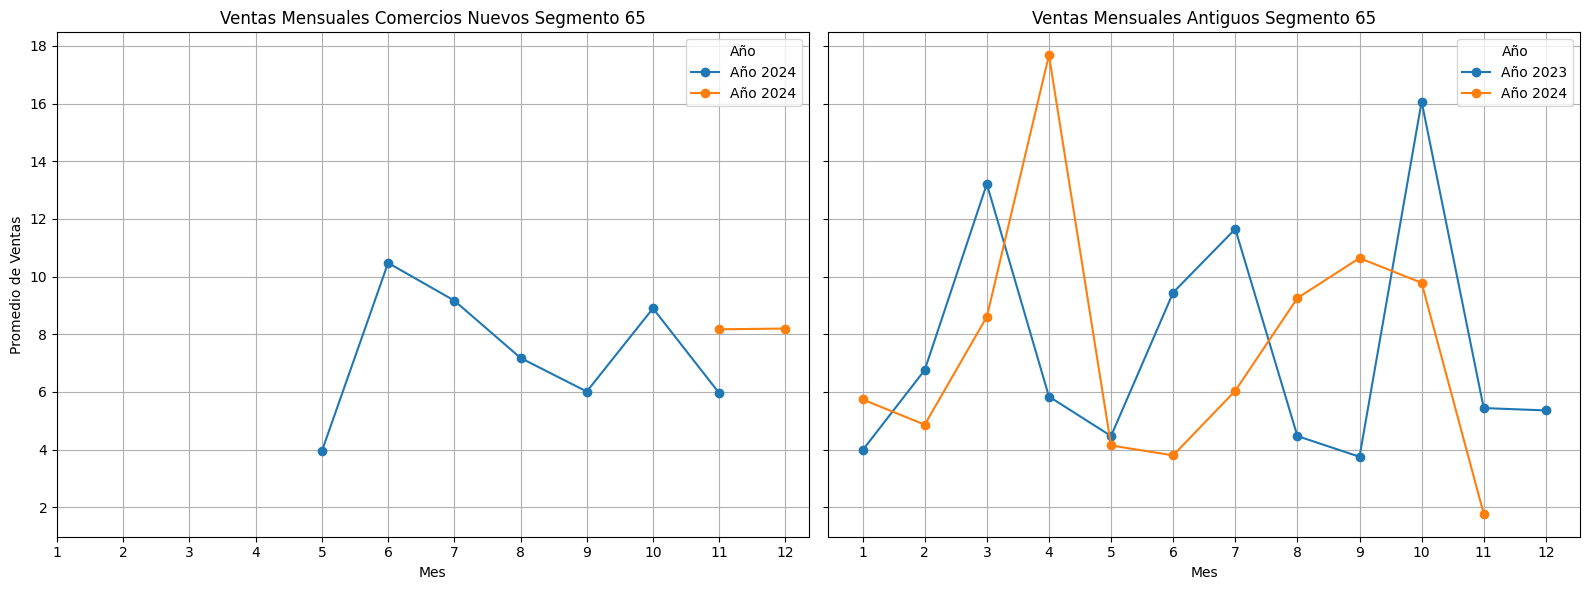

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

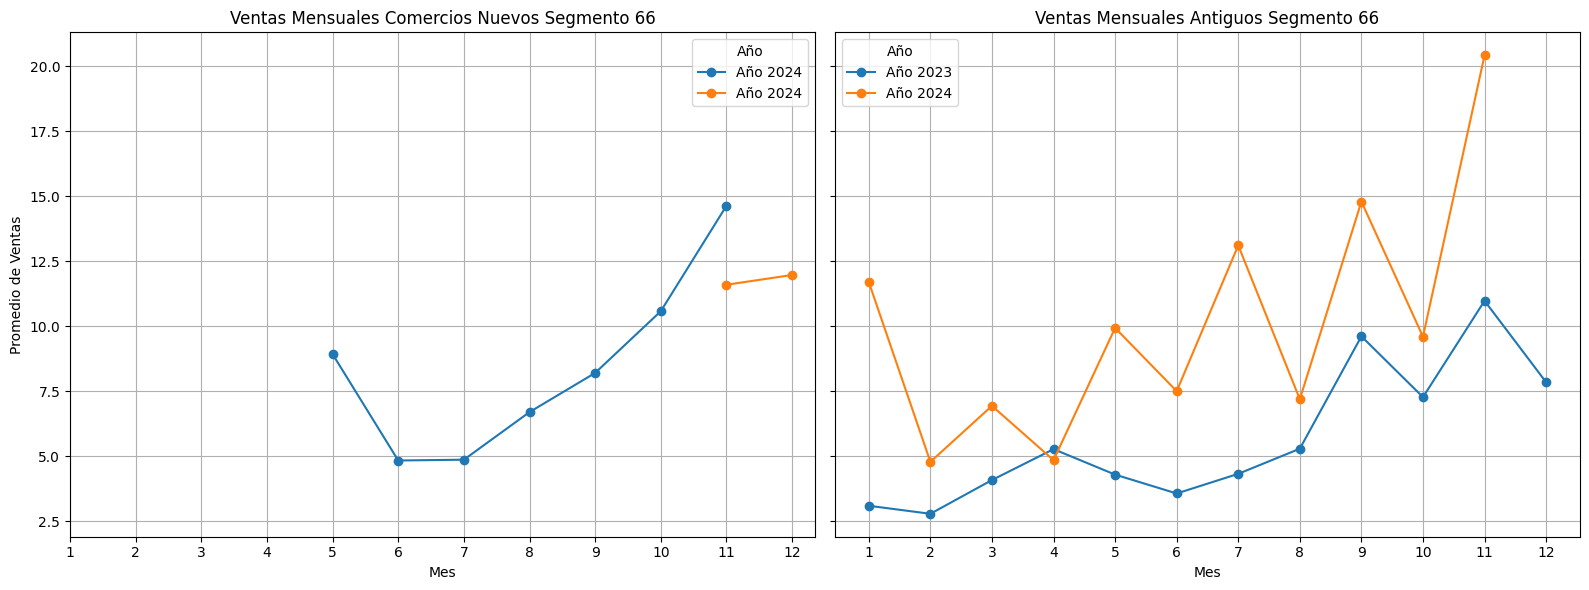

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

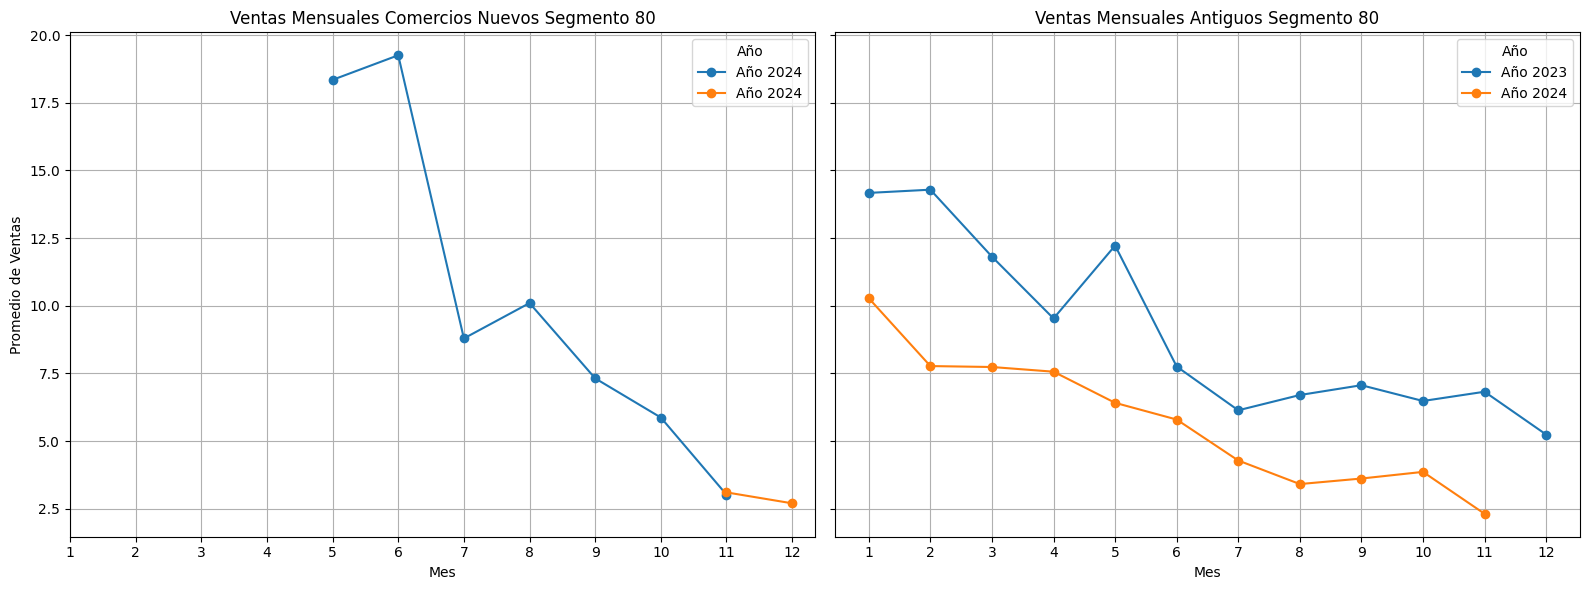

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

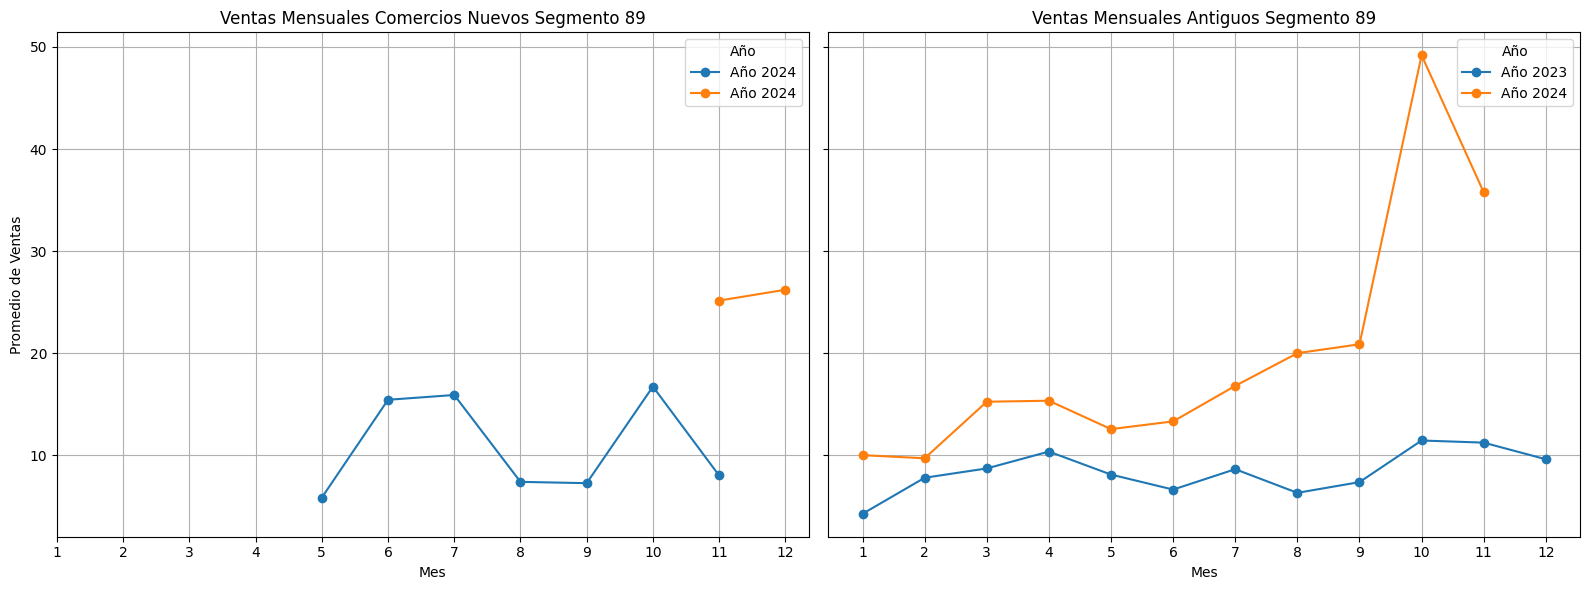

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

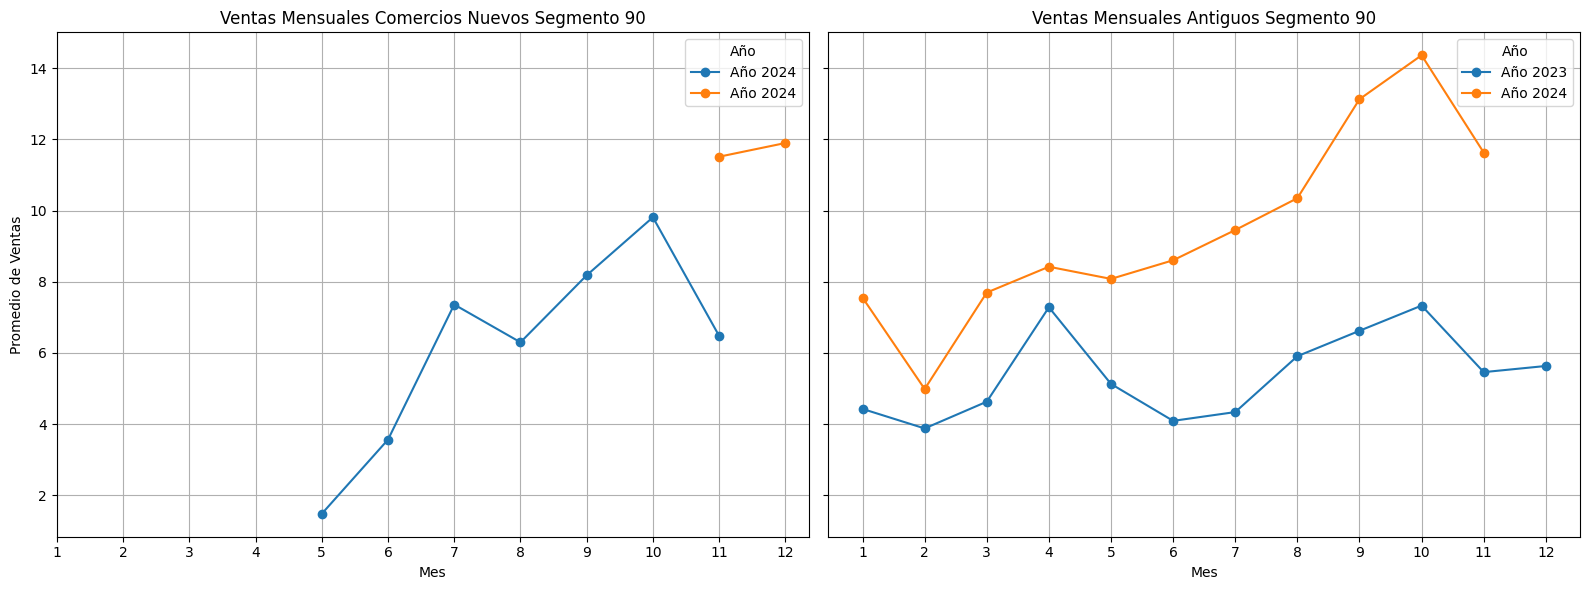

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

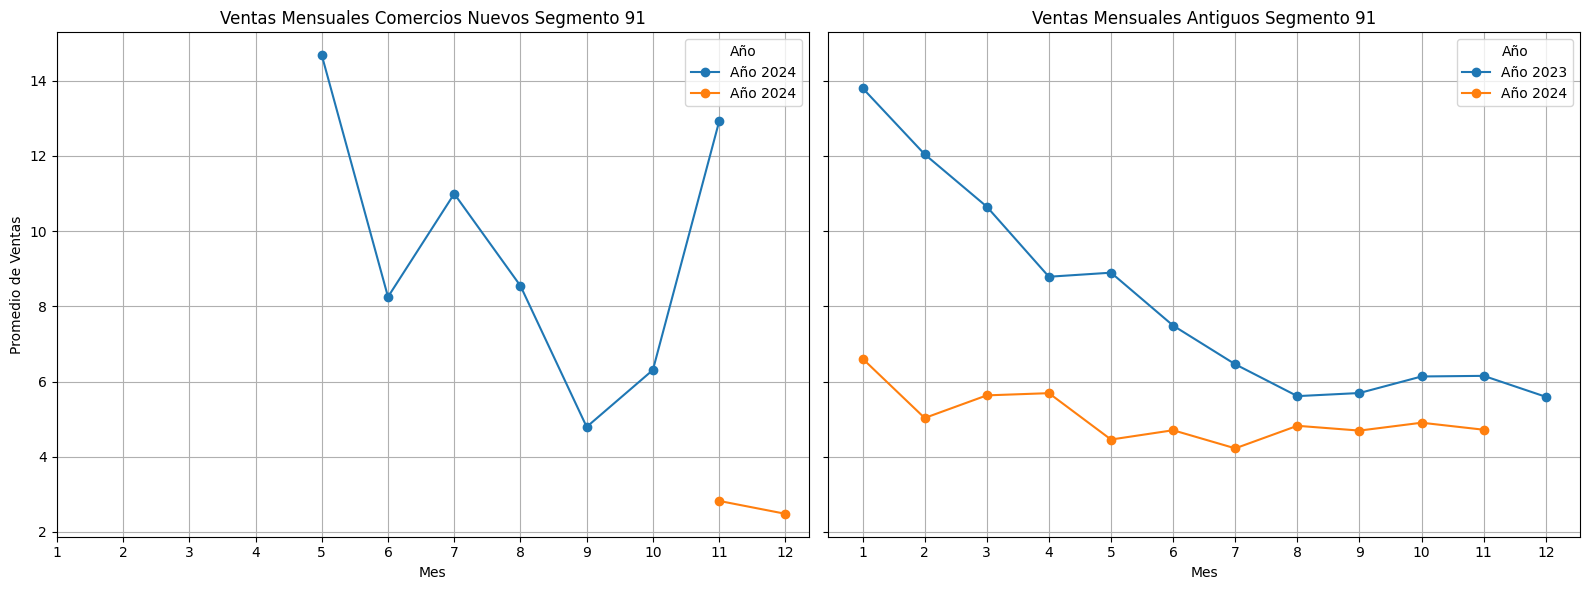

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

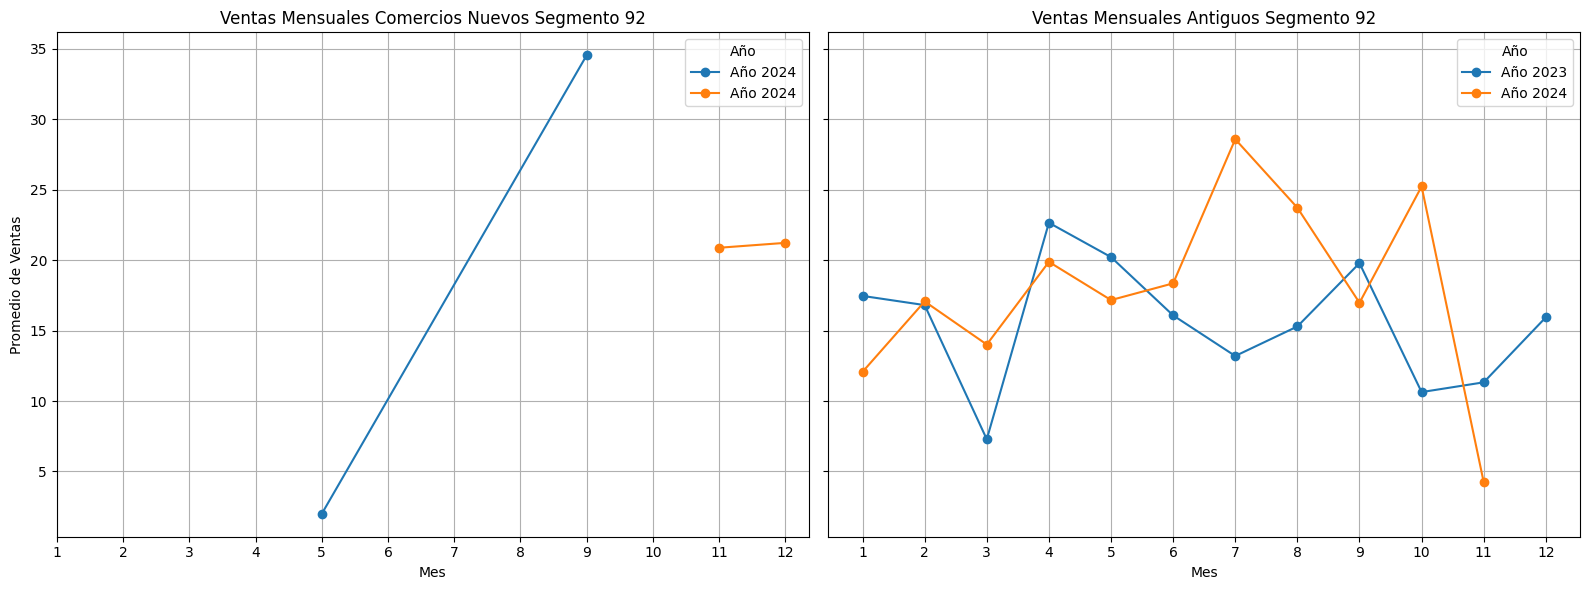

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

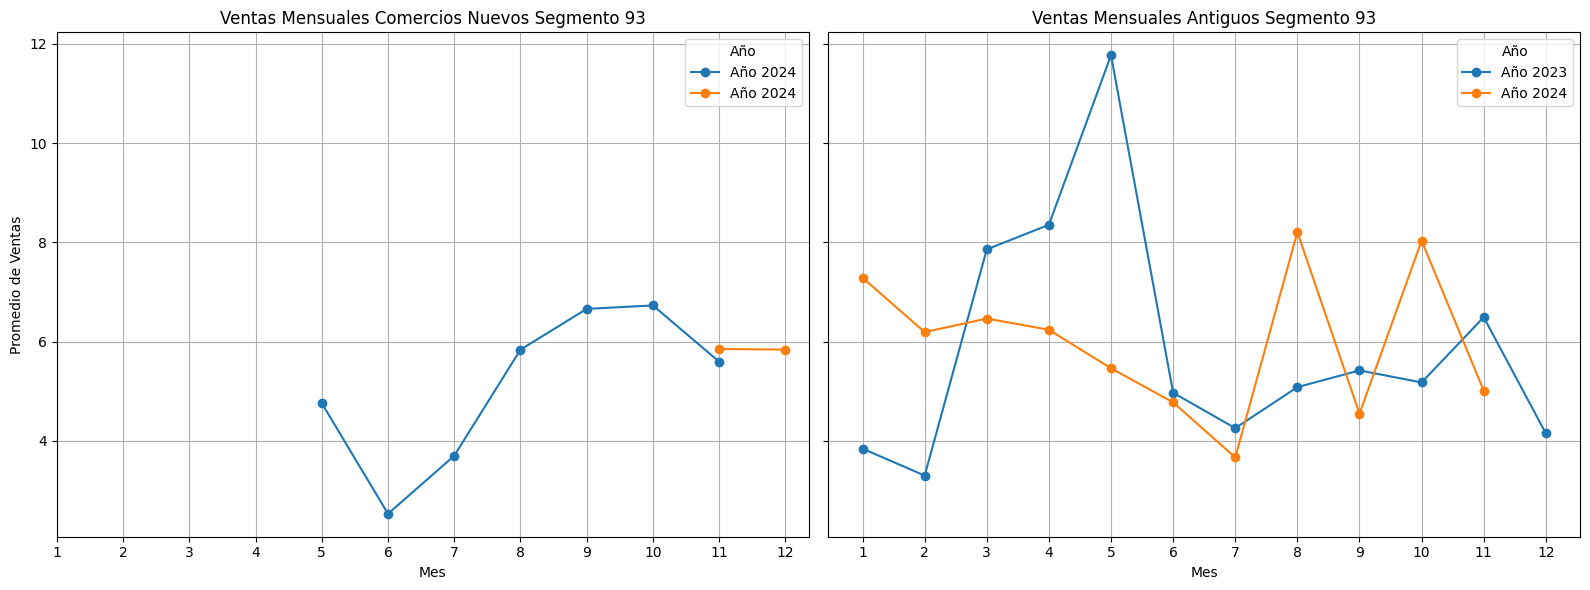

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

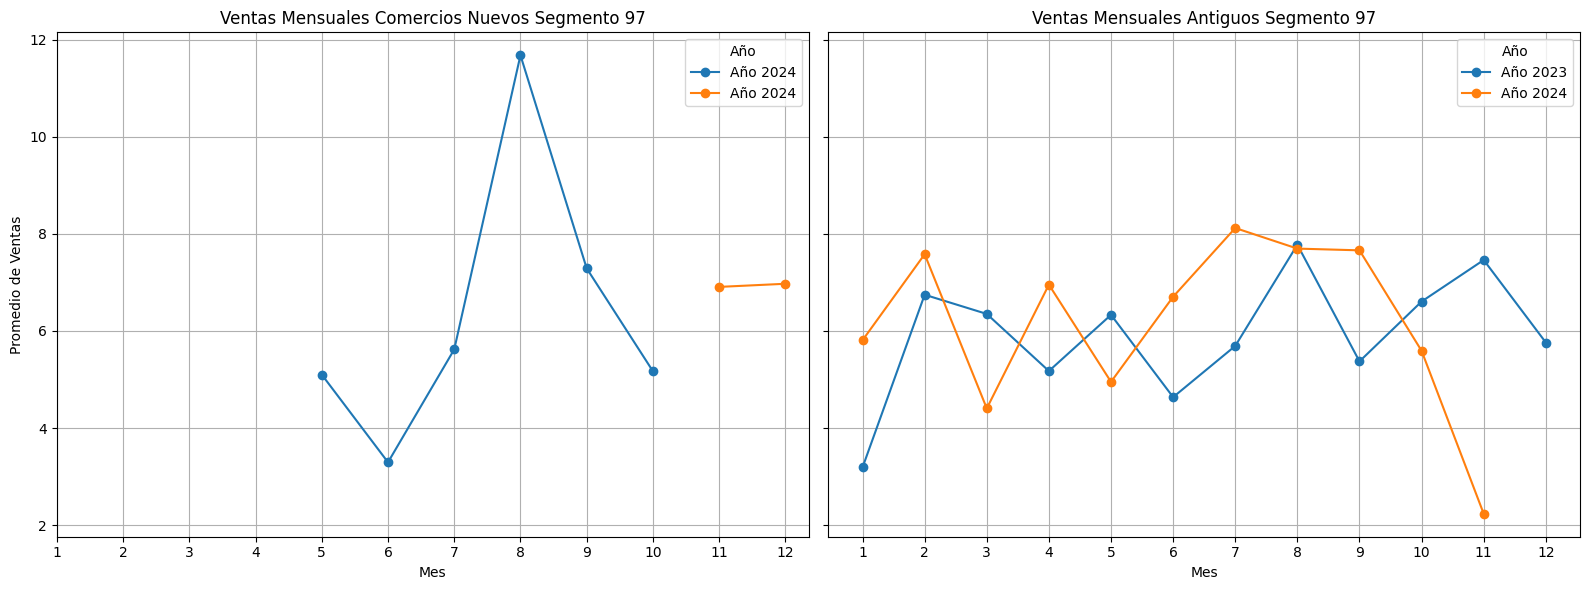

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

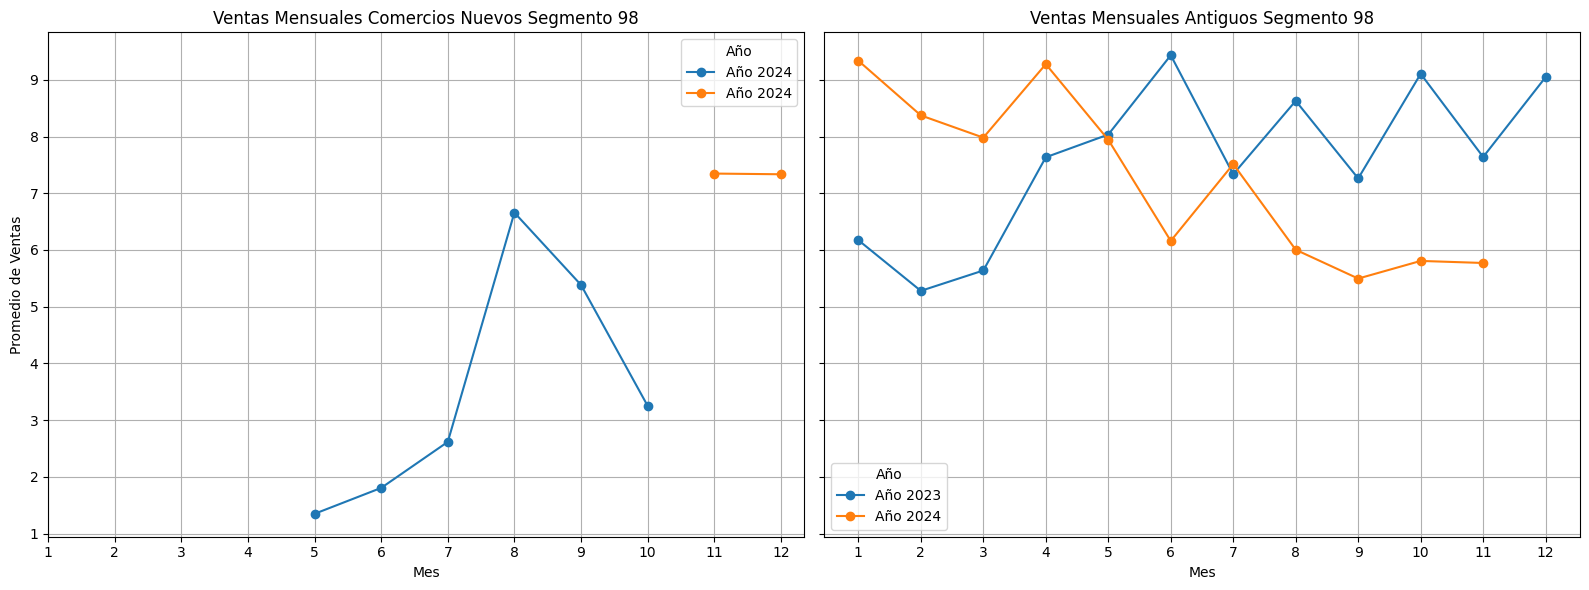

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

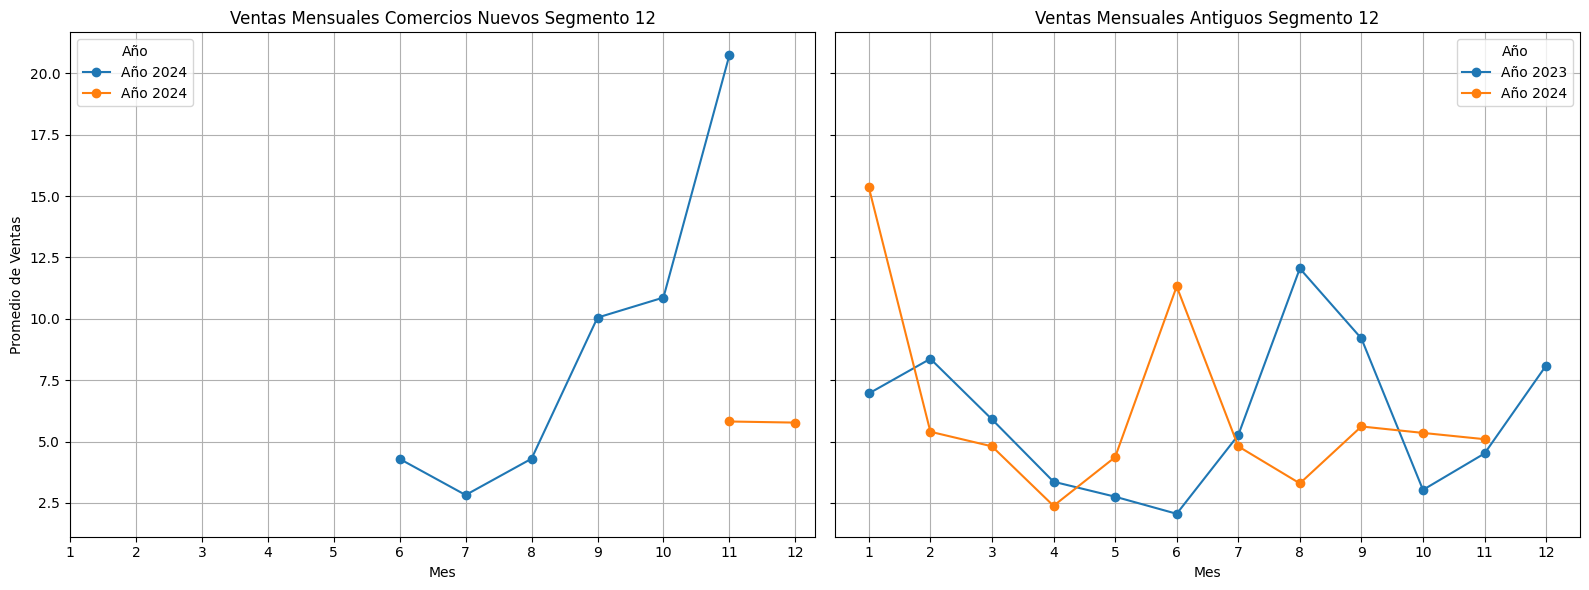

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

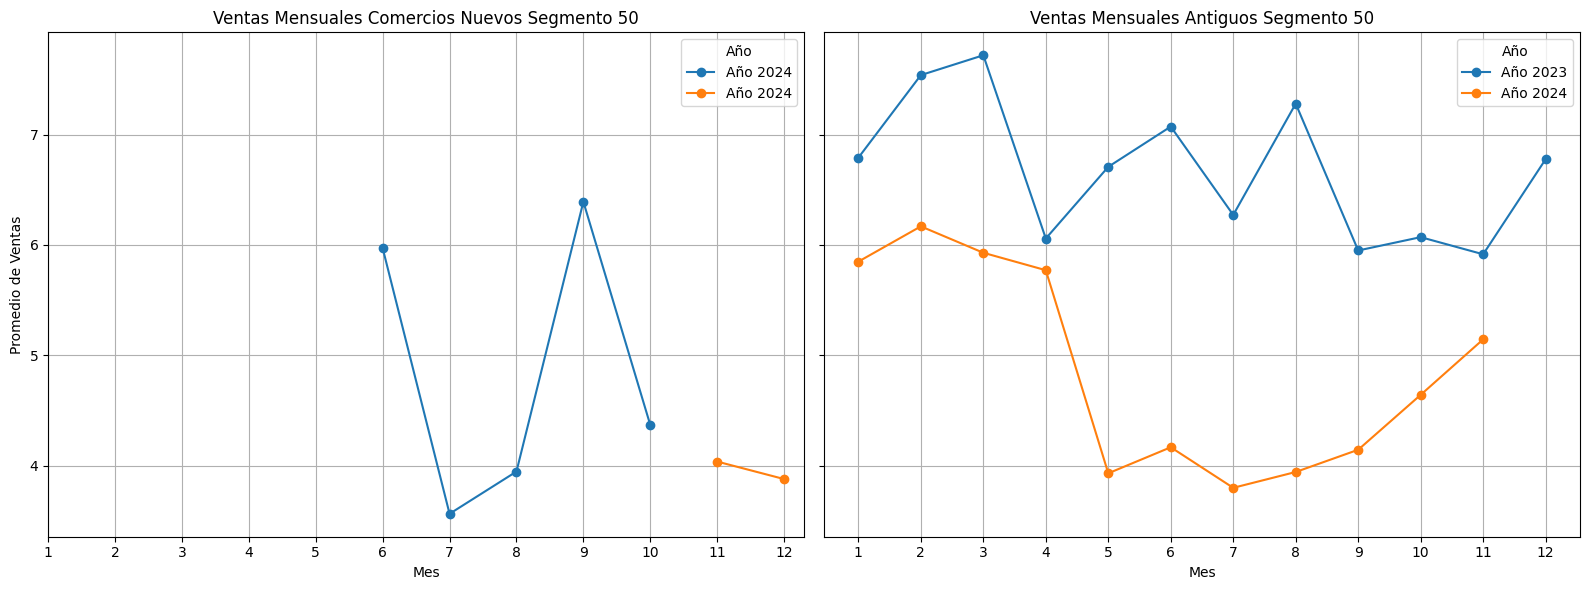

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

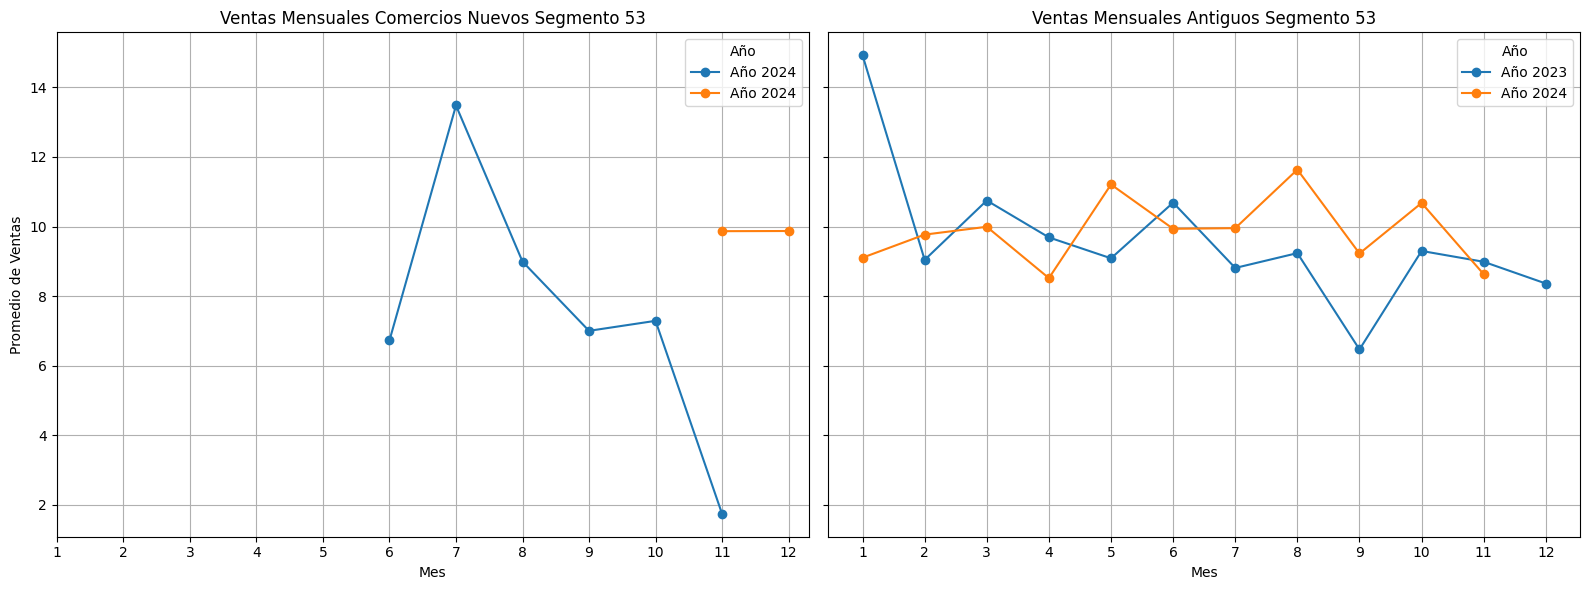

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

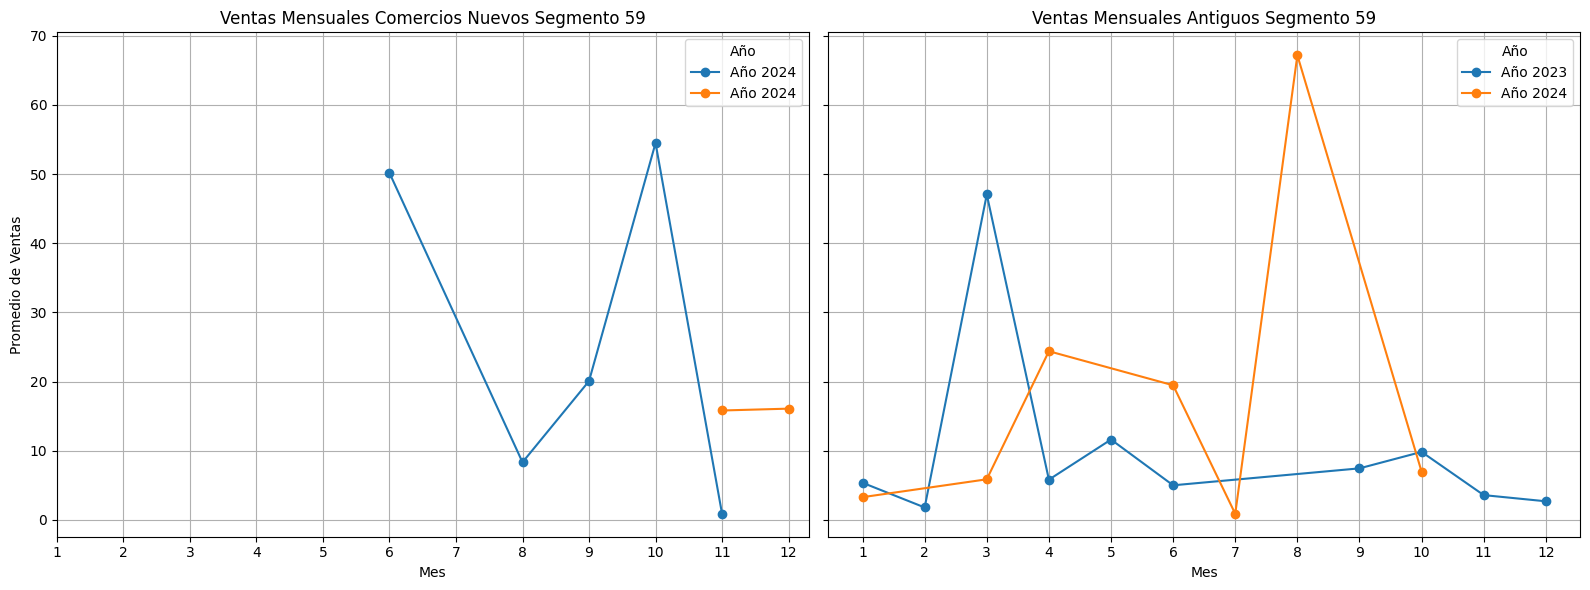

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

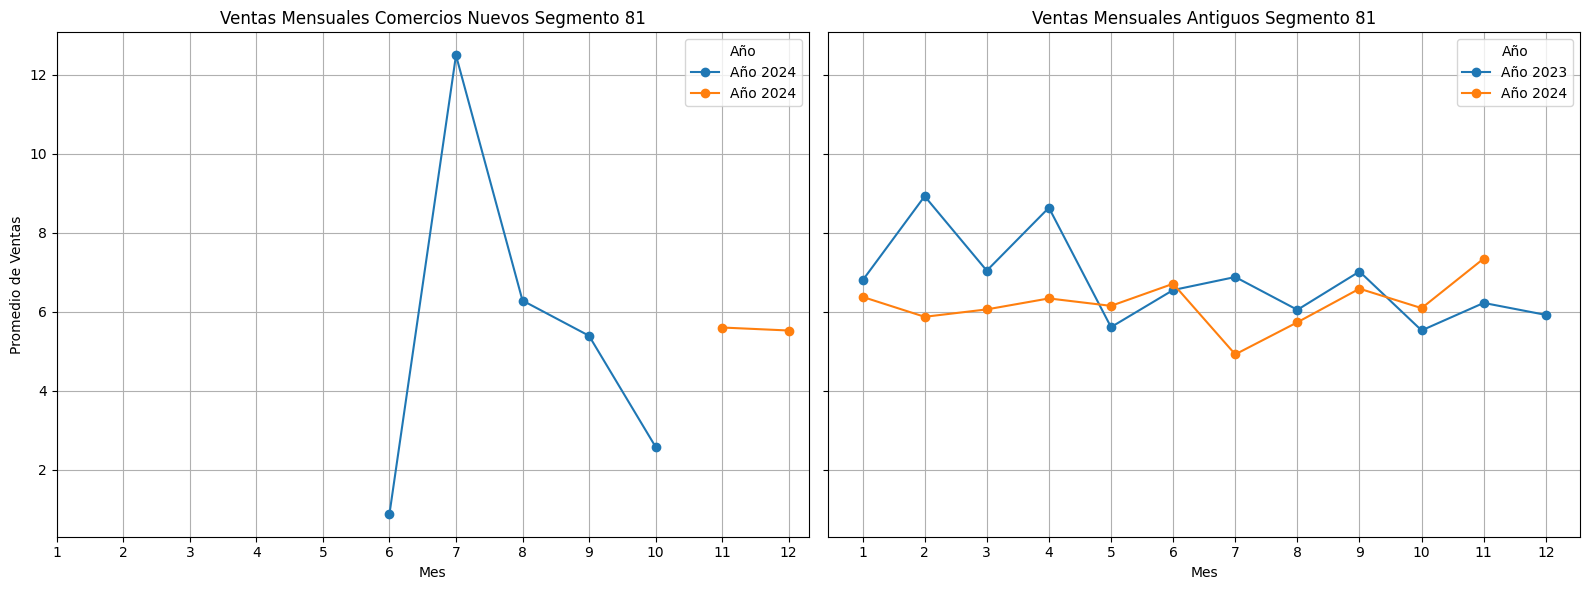

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

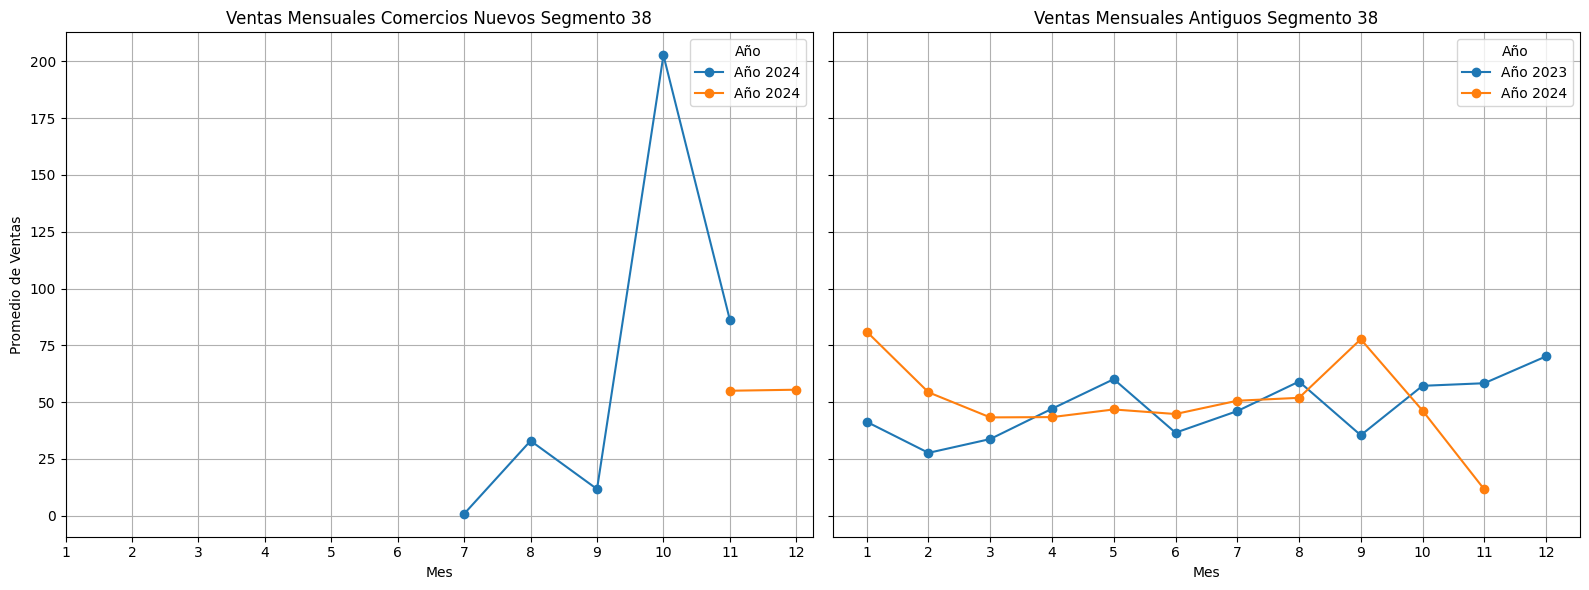

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

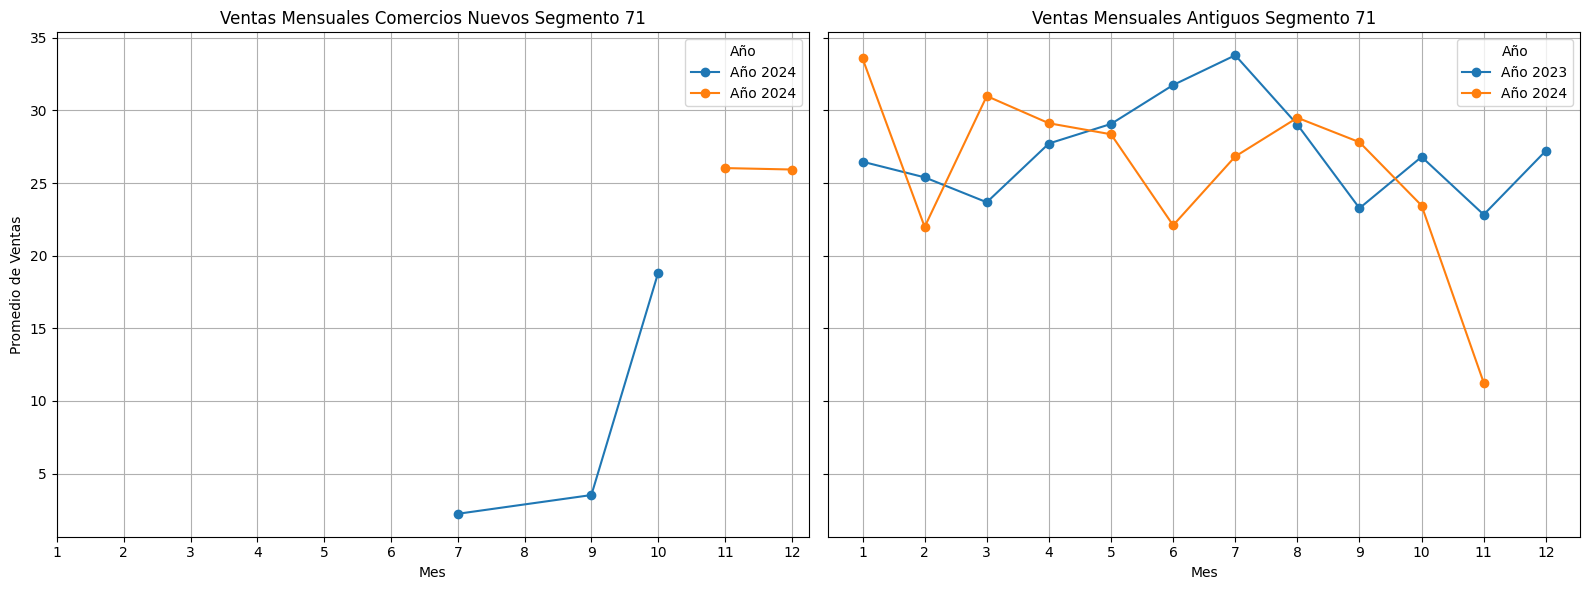

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

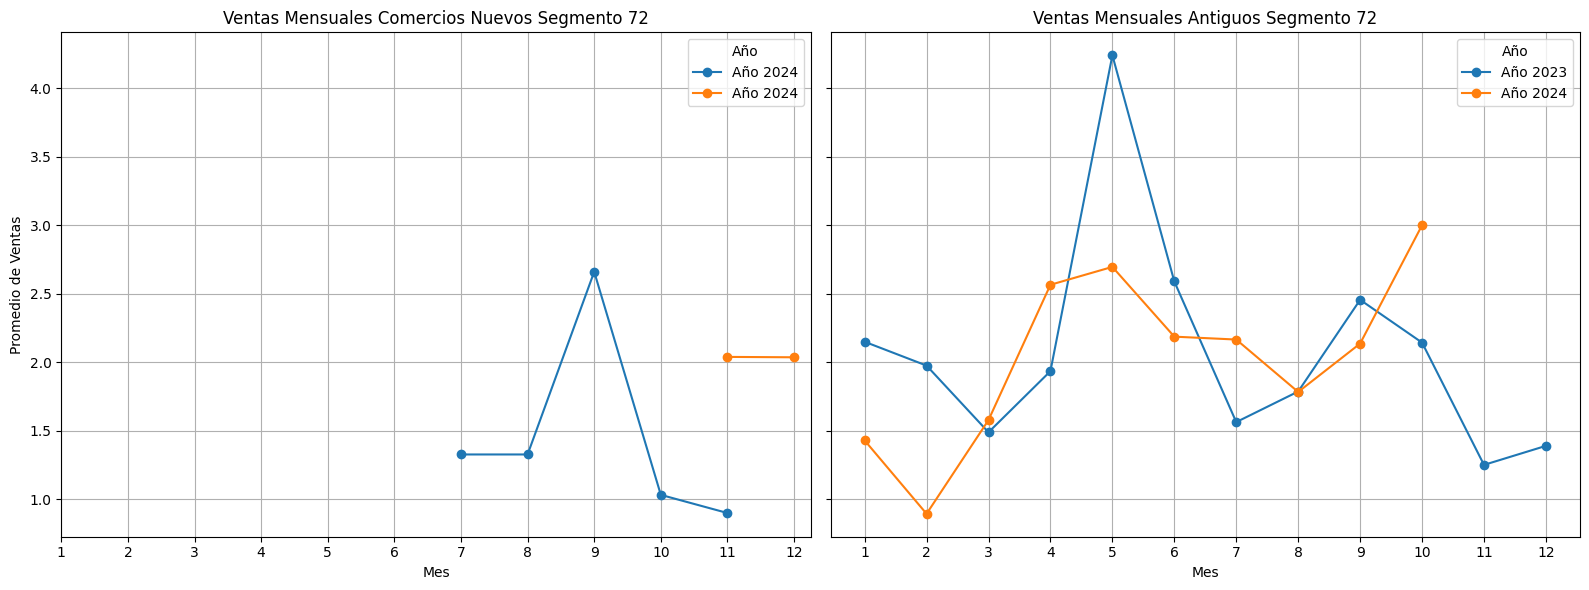

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

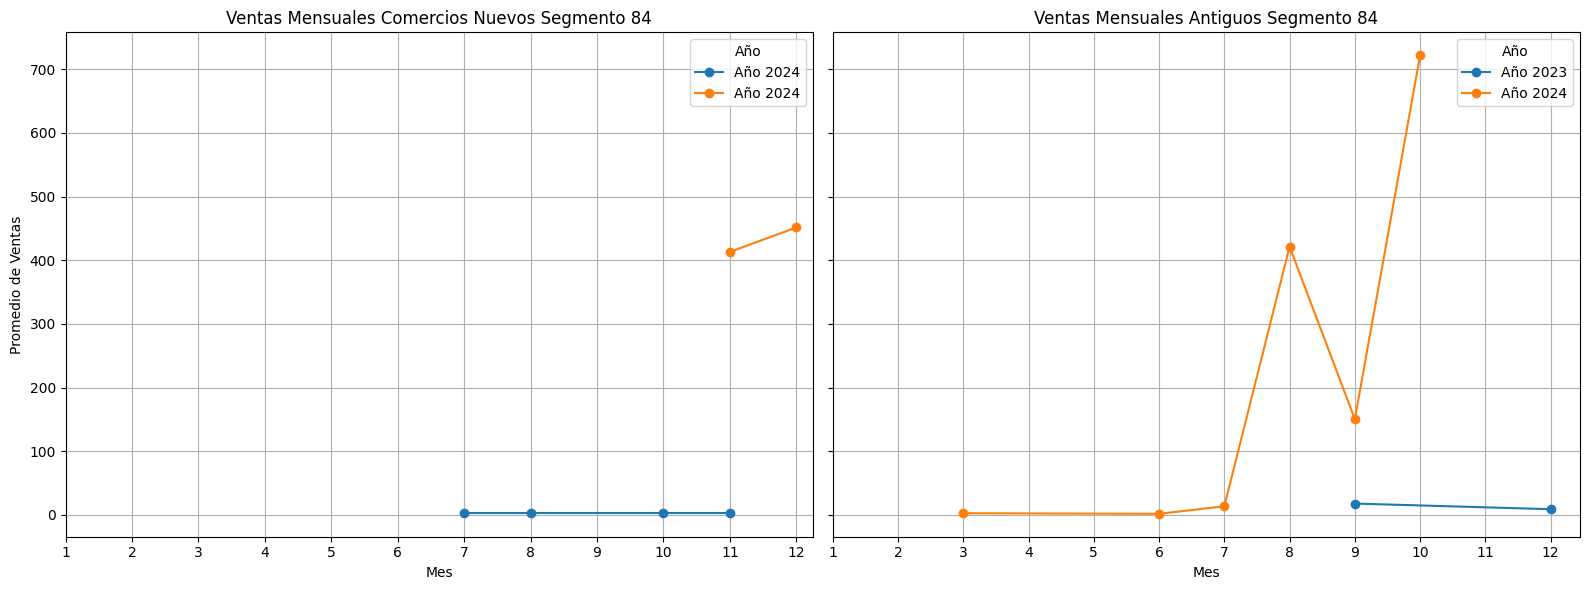

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

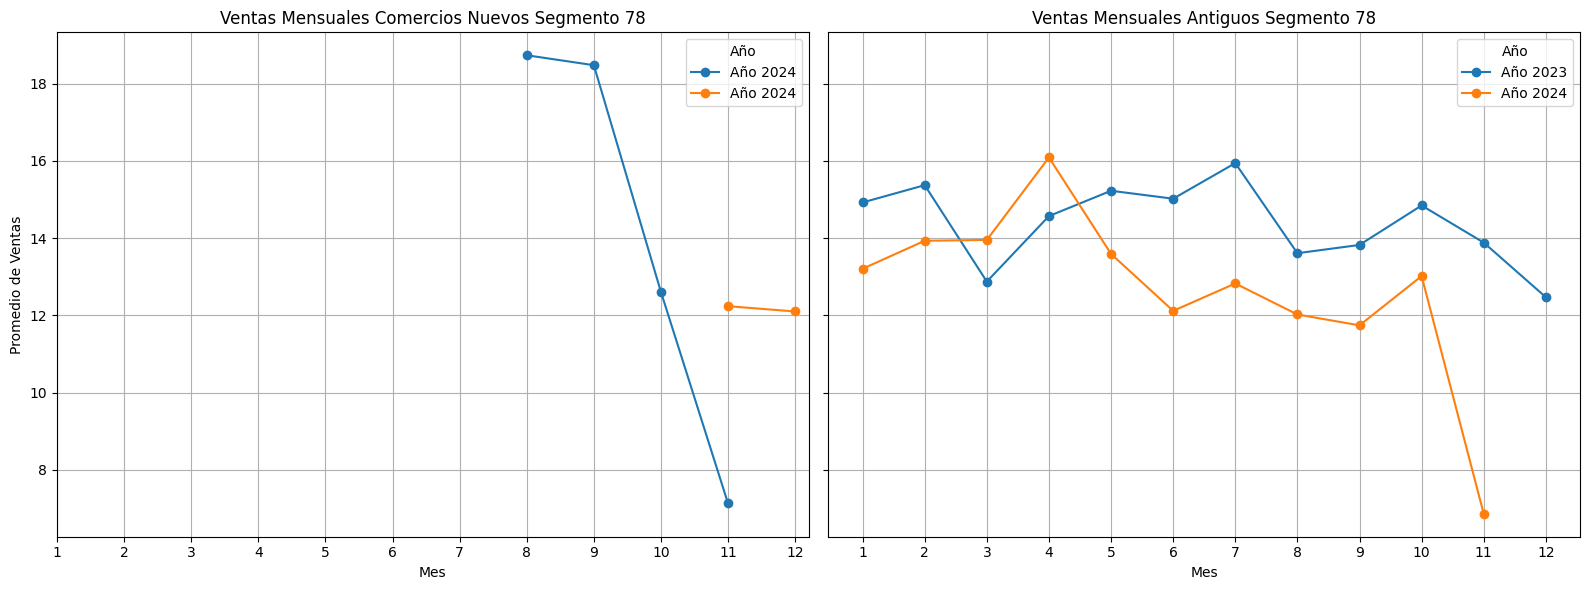

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

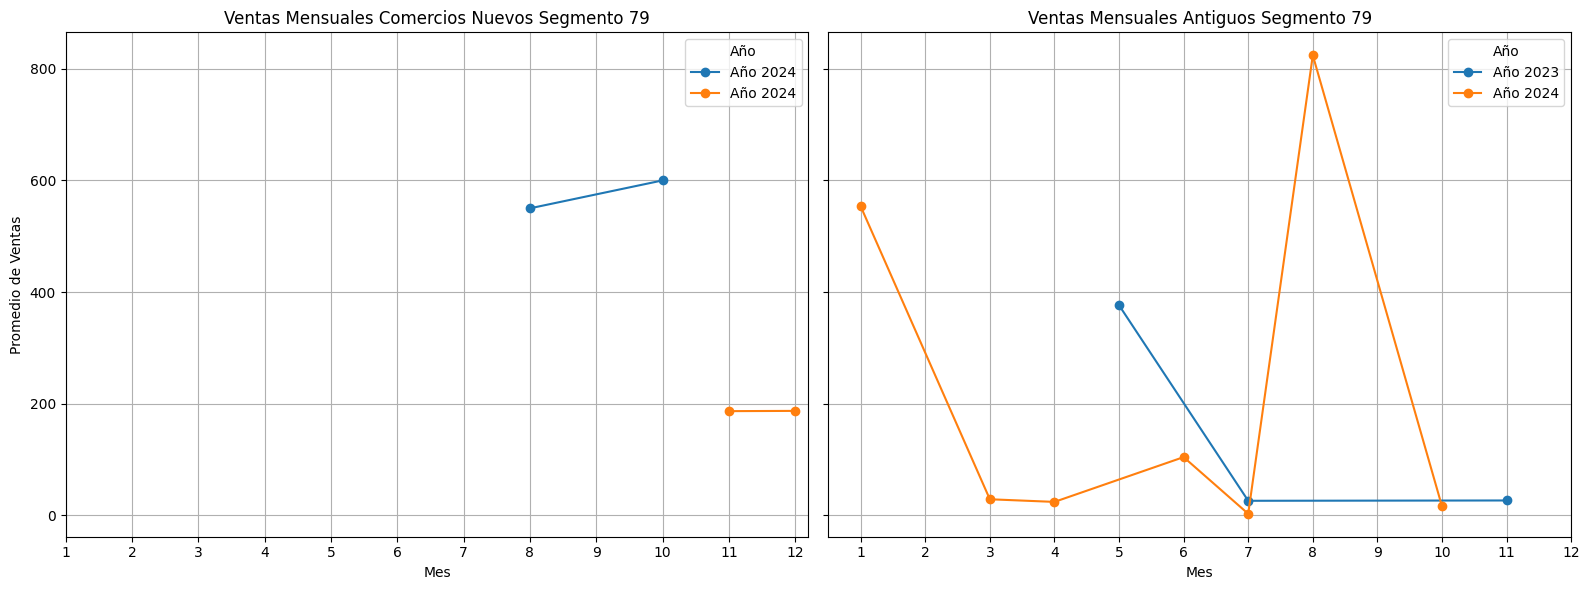

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Año"] = datosgraficos["time"].dt.year
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosgraficos["Mes"] = datosgraficos["time"].dt.month
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19892\2001708293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

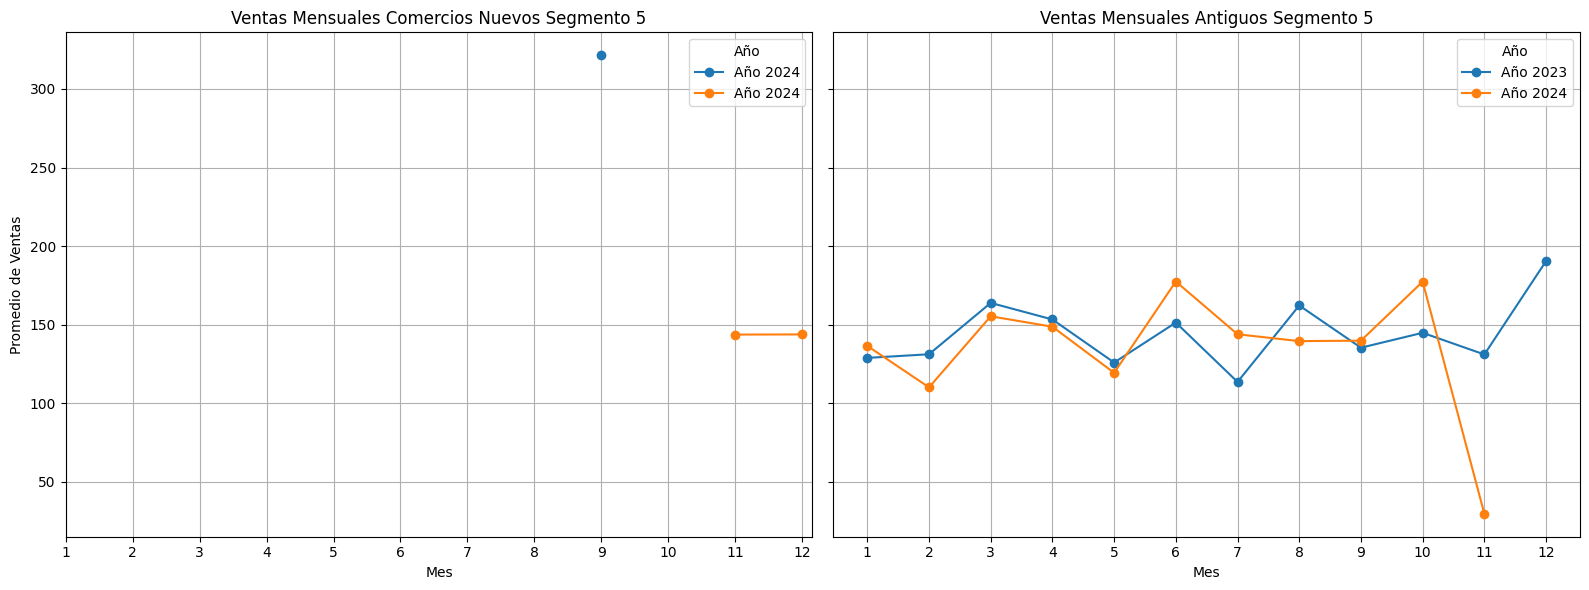

In [73]:
import matplotlib.pyplot as plt


for segmento in datos_mensuales["Segmento"].unique():
    
    datosgraficos = datos_mensuales[datos_mensuales["Segmento"] == segmento]
    datosgraficosMenor = datos_mensuales_menor[datos_mensuales_menor["Segmento"] == segmento]
    prediccionesFinal = df_transformado[df_transformado["Segmento"] == segmento]
    
    datosgraficos["Año"] = datosgraficos["time"].dt.year
    datosgraficos["Mes"] = datosgraficos["time"].dt.month
    datosgraficosMenor["Año"] = datosgraficosMenor["time"].dt.year
    datosgraficosMenor["Mes"] = datosgraficosMenor["time"].dt.month

    prediccionesFinal["Año"] = prediccionesFinal["time"].dt.year
    prediccionesFinal["Mes"] = prediccionesFinal["time"].dt.month

    
    VentasMensualesCluster = datosgraficos.groupby(["Año", "Mes"])["Ventas_Mensuales"].mean().reset_index()
    VentasMensualesCluster_Menor = datosgraficosMenor.groupby(["Año", "Mes"])["Ventas_Mensuales"].mean().reset_index()
    prediccionesFinalCluster = prediccionesFinal.groupby(["Año", "Mes"])["Ventas_Mensuales"].mean().reset_index()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Gráfico de VentasMensualesCluster
    for año in VentasMensualesCluster["Año"].unique():
        subset = VentasMensualesCluster[VentasMensualesCluster["Año"] == año]
        axes[0].plot(subset["Mes"], subset["Ventas_Mensuales"], marker='o', linestyle='-', label=f"Año {año}")
        axes[0].plot(prediccionesFinalCluster["Mes"], prediccionesFinalCluster["Ventas_Mensuales"], marker='o', linestyle='-', label=f"Año {año}")## PREDICCIONES

    axes[0].set_title(f"Ventas Mensuales Comercios Nuevos Segmento {segmento}")
    axes[0].set_xlabel("Mes")
    axes[0].set_ylabel("Promedio de Ventas")
    axes[0].set_xticks(range(1, 13))  
    axes[0].legend(title="Año")
    axes[0].grid(True)

    # Gráfico de VentasMensualesCluster_Menor
    for año in VentasMensualesCluster_Menor["Año"].unique():
        subset = VentasMensualesCluster_Menor[VentasMensualesCluster_Menor["Año"] == año]
        axes[1].plot(subset["Mes"], subset["Ventas_Mensuales"], marker='o', linestyle='-', label=f"Año {año}")

    axes[1].set_title(f"Ventas Mensuales Antiguos Segmento {segmento}")
    axes[1].set_xlabel("Mes")
    axes[1].set_xticks(range(1, 13))  
    axes[1].legend(title="Año")
    axes[1].grid(True)

    
    plt.tight_layout()
    plt.show()
